# Exploratory Data Analysis - Cadenza CLIP1 Challenge
## ICASSP 2026: Lyric Intelligibility Prediction

This notebook performs data analysis on the Cadenza dataset.

### imports and basic setup

In [ ]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

from wordfreq import word_frequency
import Levenshtein

# Set up plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['font.size'] = 10

PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'code_assignment_1' else Path.cwd()
DATA_ROOT = PROJECT_ROOT / "data" / "cadenza_data"
TRAIN_METADATA_PATH = DATA_ROOT / "metadata" / "train_metadata.json"
SIGNALS_DIR = DATA_ROOT / "train" / "signals"
UNPROCESSED_DIR = DATA_ROOT / "train" / "unprocessed"
PLOT_DIR = PROJECT_ROOT / "plots_assignment_1"

print(f"Project path: {PROJECT_ROOT}")
print(f"Data path: {DATA_ROOT}")
print(f"Metadata check: {TRAIN_METADATA_PATH.exists()}")
print(f"Plots generation path: {PLOT_DIR}")


Project path: g:\My Drive\musab\BSCS 14B Musab\Musab BSCS 14B files\Semester 3\Artificial Intelligence\sem_3_ai_sem_proj
Data path: g:\My Drive\musab\BSCS 14B Musab\Musab BSCS 14B files\Semester 3\Artificial Intelligence\sem_3_ai_sem_proj\data\cadenza_data
Metadata check: True
Plots generation path: g:\My Drive\musab\BSCS 14B Musab\Musab BSCS 14B files\Semester 3\Artificial Intelligence\sem_3_ai_sem_proj\plots



### Data loading and basic idea of the dataset layout

In [2]:
print("Loading metadata...")
with open(TRAIN_METADATA_PATH, 'r') as f:
    metadata = json.load(f)

df = pd.DataFrame(metadata)
print(f"Full dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("")
print(f"Target variable (correctness) distribution:")
print(df['correctness'].describe())

print("\nHearing loss distribution in full dataset:")
print(df['hearing_loss'].value_counts(normalize=True))


print(f"\nRows with '#' responses (no words identified): {(df['response'] == '#').sum()}")
print(f"These represent the lowest intelligibility cases (correctness = 0.0)")

# Display first few rows
print("\nFirst few rows of metadata:")
df.head()


Loading metadata...
Full dataset shape: (8802, 7)
Columns: ['signal', 'prompt', 'response', 'n_words', 'words_correct', 'correctness', 'hearing_loss']

Target variable (correctness) distribution:
count    8802.000000
mean        0.430278
std         0.357664
min         0.000000
25%         0.000000
50%         0.400000
75%         0.750000
max         1.000000
Name: correctness, dtype: float64

Hearing loss distribution in full dataset:
hearing_loss
Mild        0.333447
Moderate    0.333333
No Loss     0.333220
Name: proportion, dtype: float64

Rows with '#' responses (no words identified): 1265
These represent the lowest intelligibility cases (correctness = 0.0)

First few rows of metadata:


signal                                          prompt  \
0  c221f2084c780e8f212f4697                          cos you better hold on   
1  63de05fbfcab2d7748b83cb3                    And then lower it down again   
2  cf74c013a02d82d04254a910   the blind sleep, and the deaf and dumb sleep    
3  56f3fb4847d2c90f38e8e983  a street a couple of cars and maybe some trees   
4  b2486a8e181f84acd2db4d61                    in my mind I can see is fine   

                                   response  n_words  words_correct  \
0                                         #        5              0   
1      I don't know where it's all the same        6              1   
2  The blind sleep and the deaf under sleep        9              7   
3                                         #       10              0   
4                                         #        8              0   

   correctness hearing_loss  
0     0.000000     Moderate  
1     0.166667         Mild  
2     0.777778      No Loss  
3     0.000000     Moderate  
4     0.000000     Moderate

### Figure 1: Target Distribution & Figure 2: Signal Comparison

Generating Figure 1: Target Distribution...


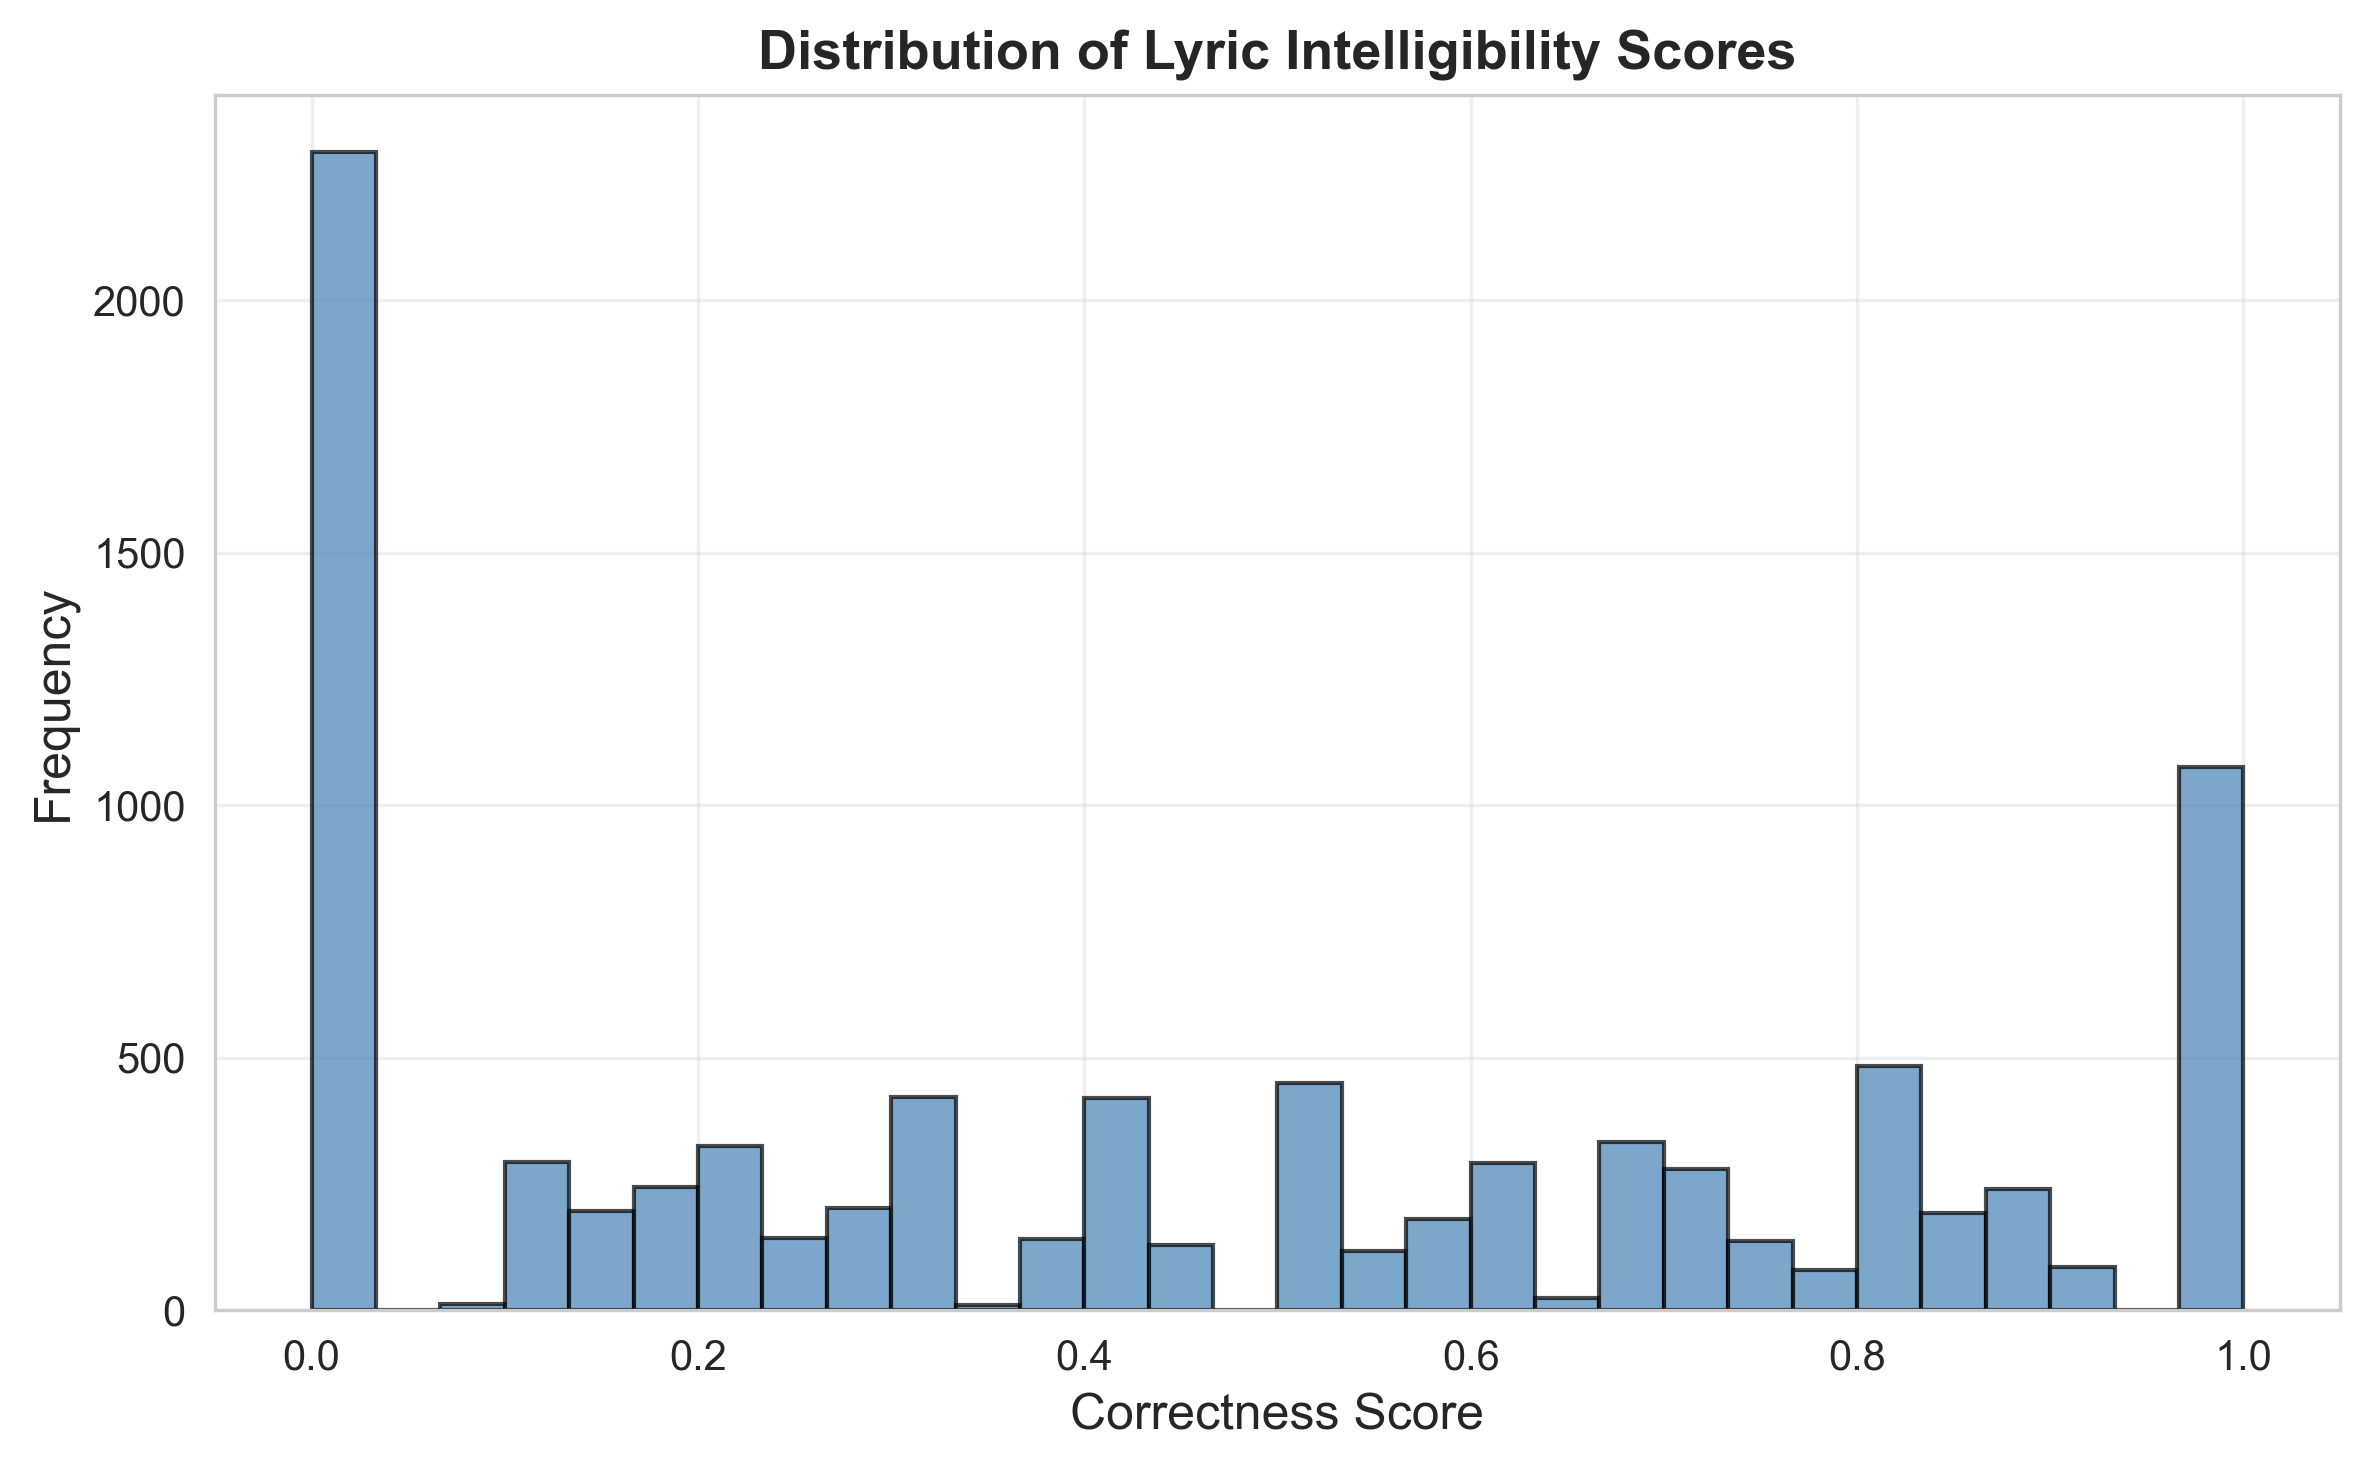

Figure 1 saved successfully!

Generating Figure 2: Signal Comparison...
Loading audio: c221f2084c780e8f212f4697
Original path: True
Processed path: True


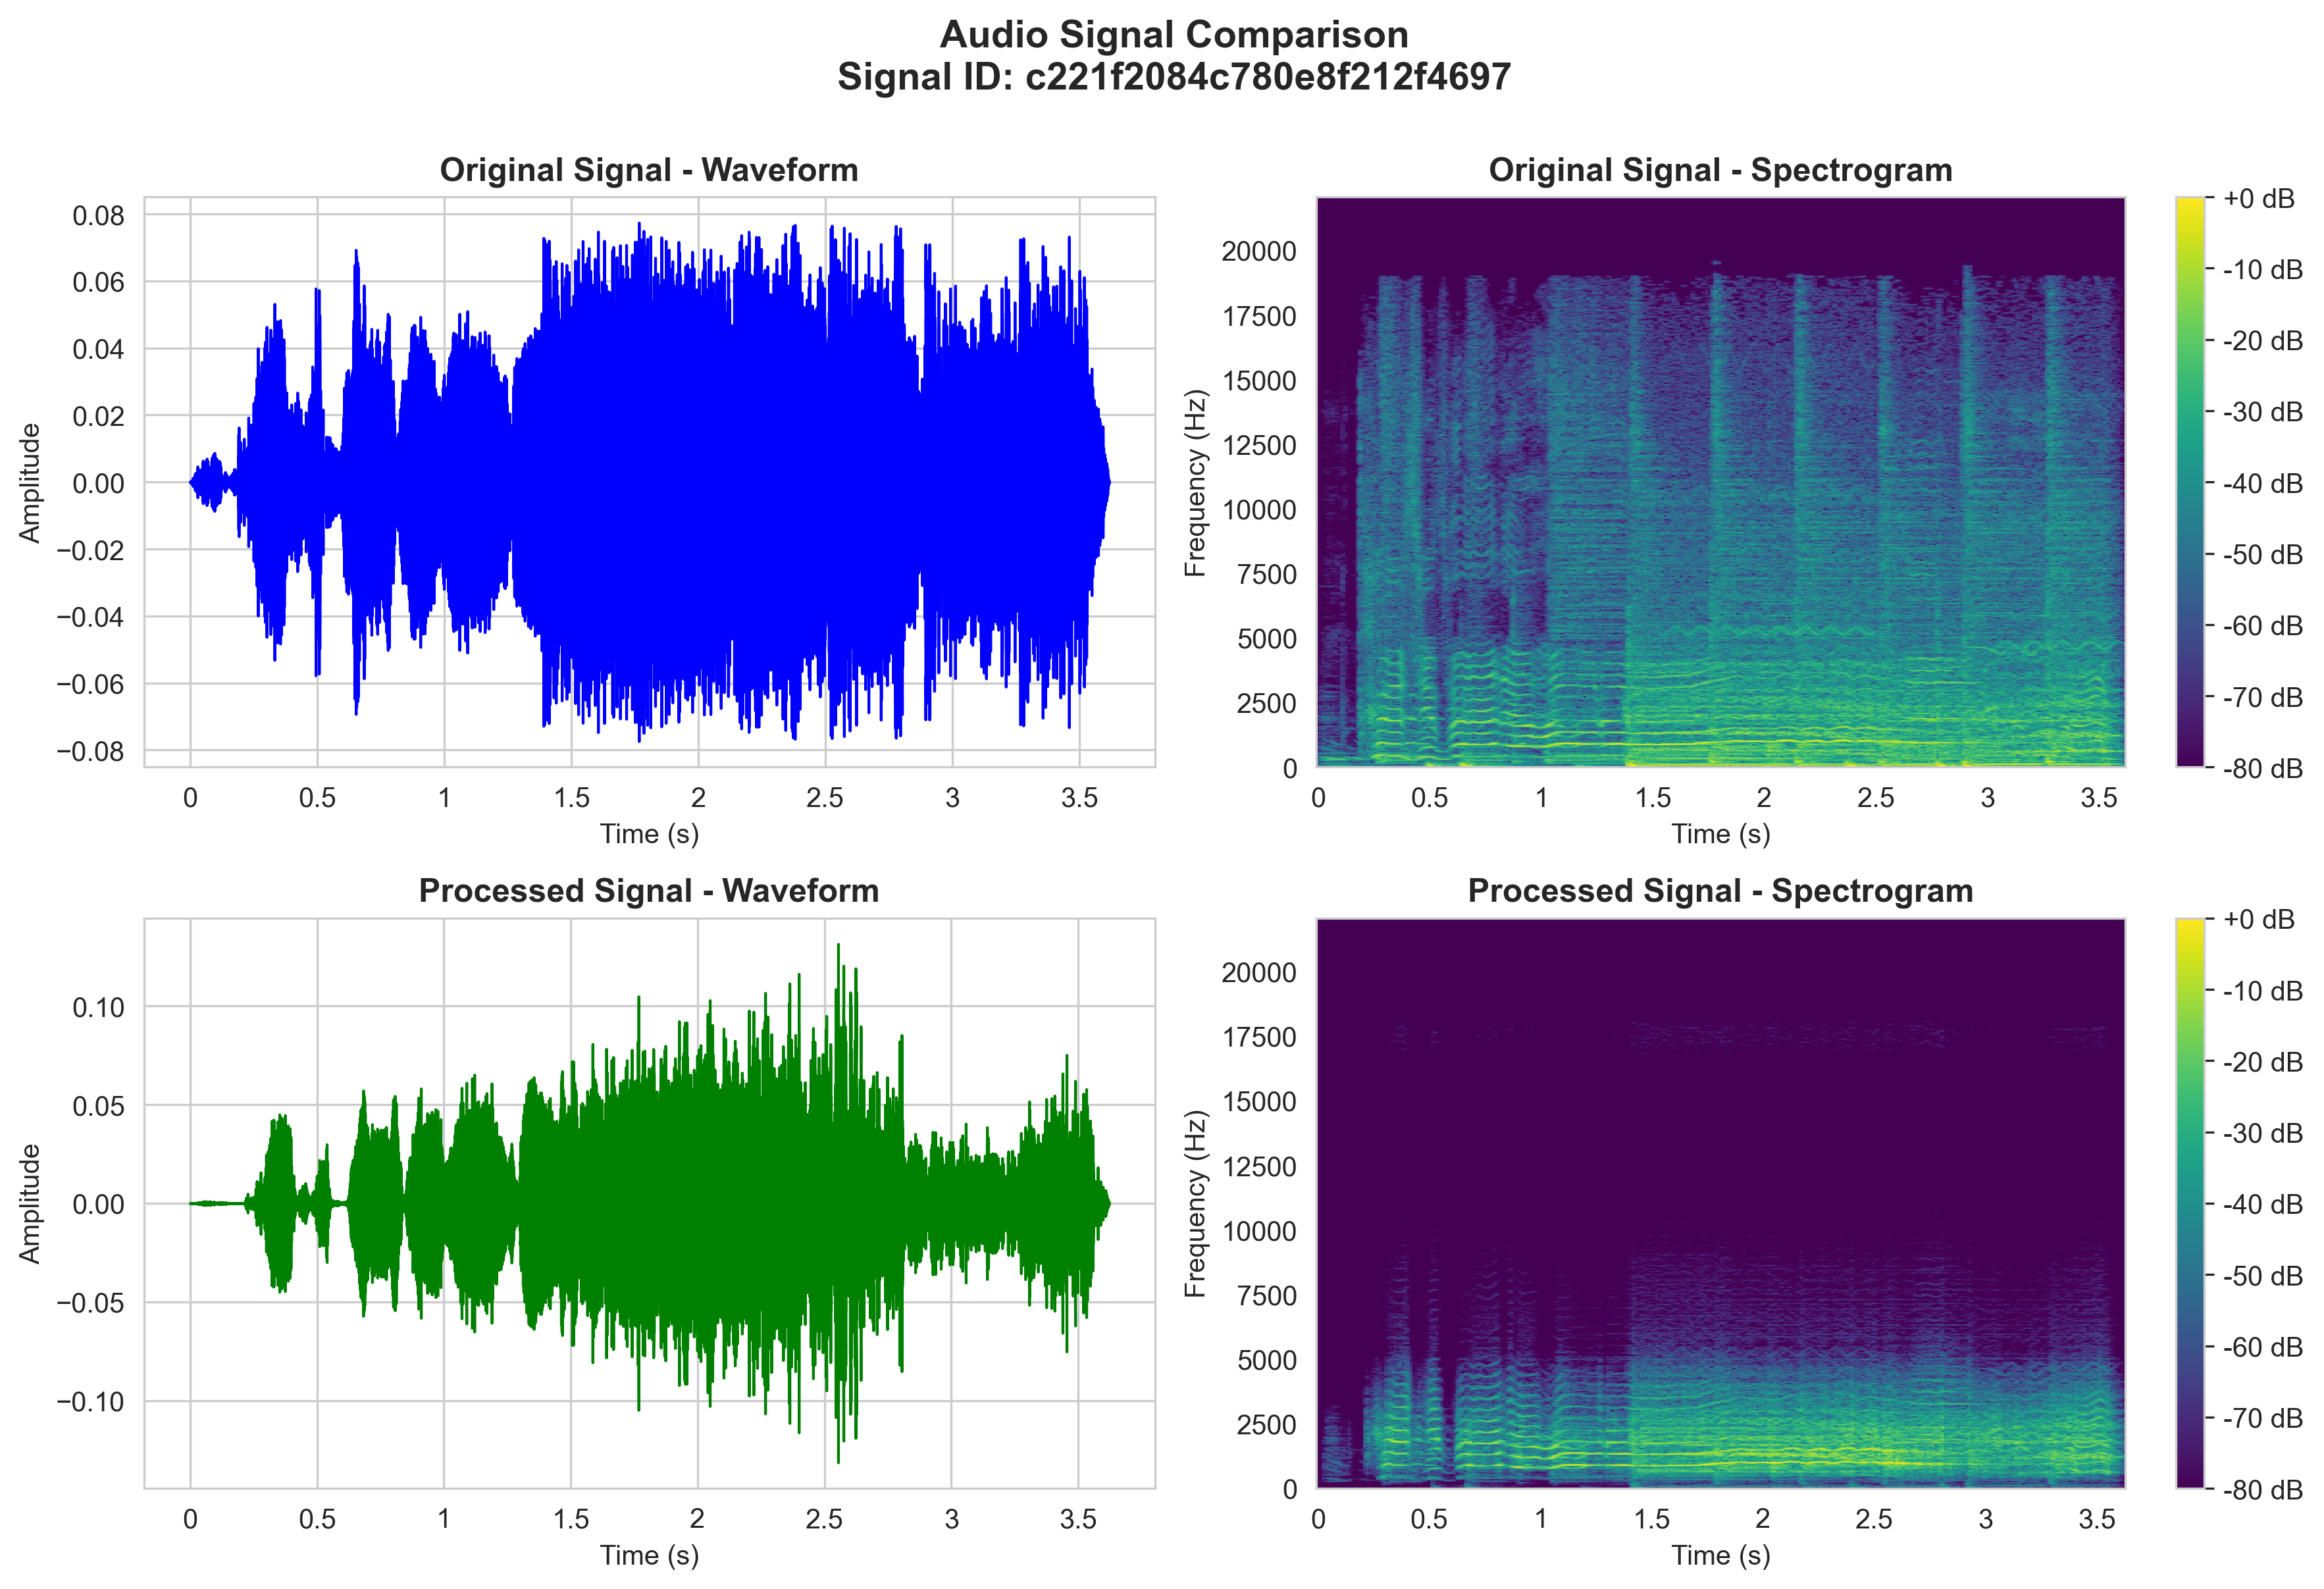

Figure 2 saved successfully!



In [3]:
# FIGURE 1: Histogram of Correctness (Target Distribution)
print("Generating Figure 1: Target Distribution...")
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(df['correctness'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax.set_xlabel('Correctness Score', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Lyric Intelligibility Scores', 
             fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
fig.savefig(PLOT_DIR / "figure_1_target_distribution.pdf", bbox_inches='tight')
plt.show()
print("Figure 1 saved successfully!\n")

# FIGURE 2: Waveform and Spectrogram Comparison
print("Generating Figure 2: Signal Comparison...")

# Select a sample audio file from the full dataset
sample_row = df.iloc[0]
signal_id = sample_row['signal']

# Construct file paths
original_audio_path = UNPROCESSED_DIR / f"{signal_id}_unproc.flac"
processed_audio_path = SIGNALS_DIR / f"{signal_id}.flac"

print(f"Loading audio: {signal_id}")
print(f"Original path: {original_audio_path.exists()}")
print(f"Processed path: {processed_audio_path.exists()}")

# Load audio files
y_original, sr_original = librosa.load(original_audio_path, sr=None)
y_processed, sr_processed = librosa.load(processed_audio_path, sr=None)

# Create 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Original waveform
librosa.display.waveshow(y_original, sr=sr_original, ax=axes[0, 0], color='blue')
axes[0, 0].set_title('Original Signal - Waveform', fontweight='bold')
axes[0, 0].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('Amplitude')

# Original spectrogram
D_original = librosa.amplitude_to_db(np.abs(librosa.stft(y_original)), ref=np.max)
img = librosa.display.specshow(D_original, sr=sr_original, x_axis='time', y_axis='hz', ax=axes[0, 1], cmap='viridis')
axes[0, 1].set_title('Original Signal - Spectrogram', fontweight='bold')
axes[0, 1].set_xlabel('Time (s)')
axes[0, 1].set_ylabel('Frequency (Hz)')
plt.colorbar(img, ax=axes[0, 1], format='%+2.0f dB')

# Processed waveform
librosa.display.waveshow(y_processed, sr=sr_processed, ax=axes[1, 0], color='green')
axes[1, 0].set_title('Processed Signal - Waveform', fontweight='bold')
axes[1, 0].set_xlabel('Time (s)')
axes[1, 0].set_ylabel('Amplitude')

# Processed spectrogram
D_processed = librosa.amplitude_to_db(np.abs(librosa.stft(y_processed)), ref=np.max)
img = librosa.display.specshow(D_processed, sr=sr_processed, x_axis='time', y_axis='hz', ax=axes[1, 1], cmap='viridis')
axes[1, 1].set_title('Processed Signal - Spectrogram', fontweight='bold')
axes[1, 1].set_xlabel('Time (s)')
axes[1, 1].set_ylabel('Frequency (Hz)')
plt.colorbar(img, ax=axes[1, 1], format='%+2.0f dB')

plt.suptitle(f'Audio Signal Comparison\nSignal ID: {signal_id}', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
fig.savefig(PLOT_DIR / "figure_2_signal_comparison.pdf", bbox_inches='tight')
plt.show()
print("Figure 2 saved successfully!\n")


## Figure 3: Word Length & Figure 4: Word Frequency

Extra features made for 8802 rows

Generating Figure 3: Word Length Analysis...


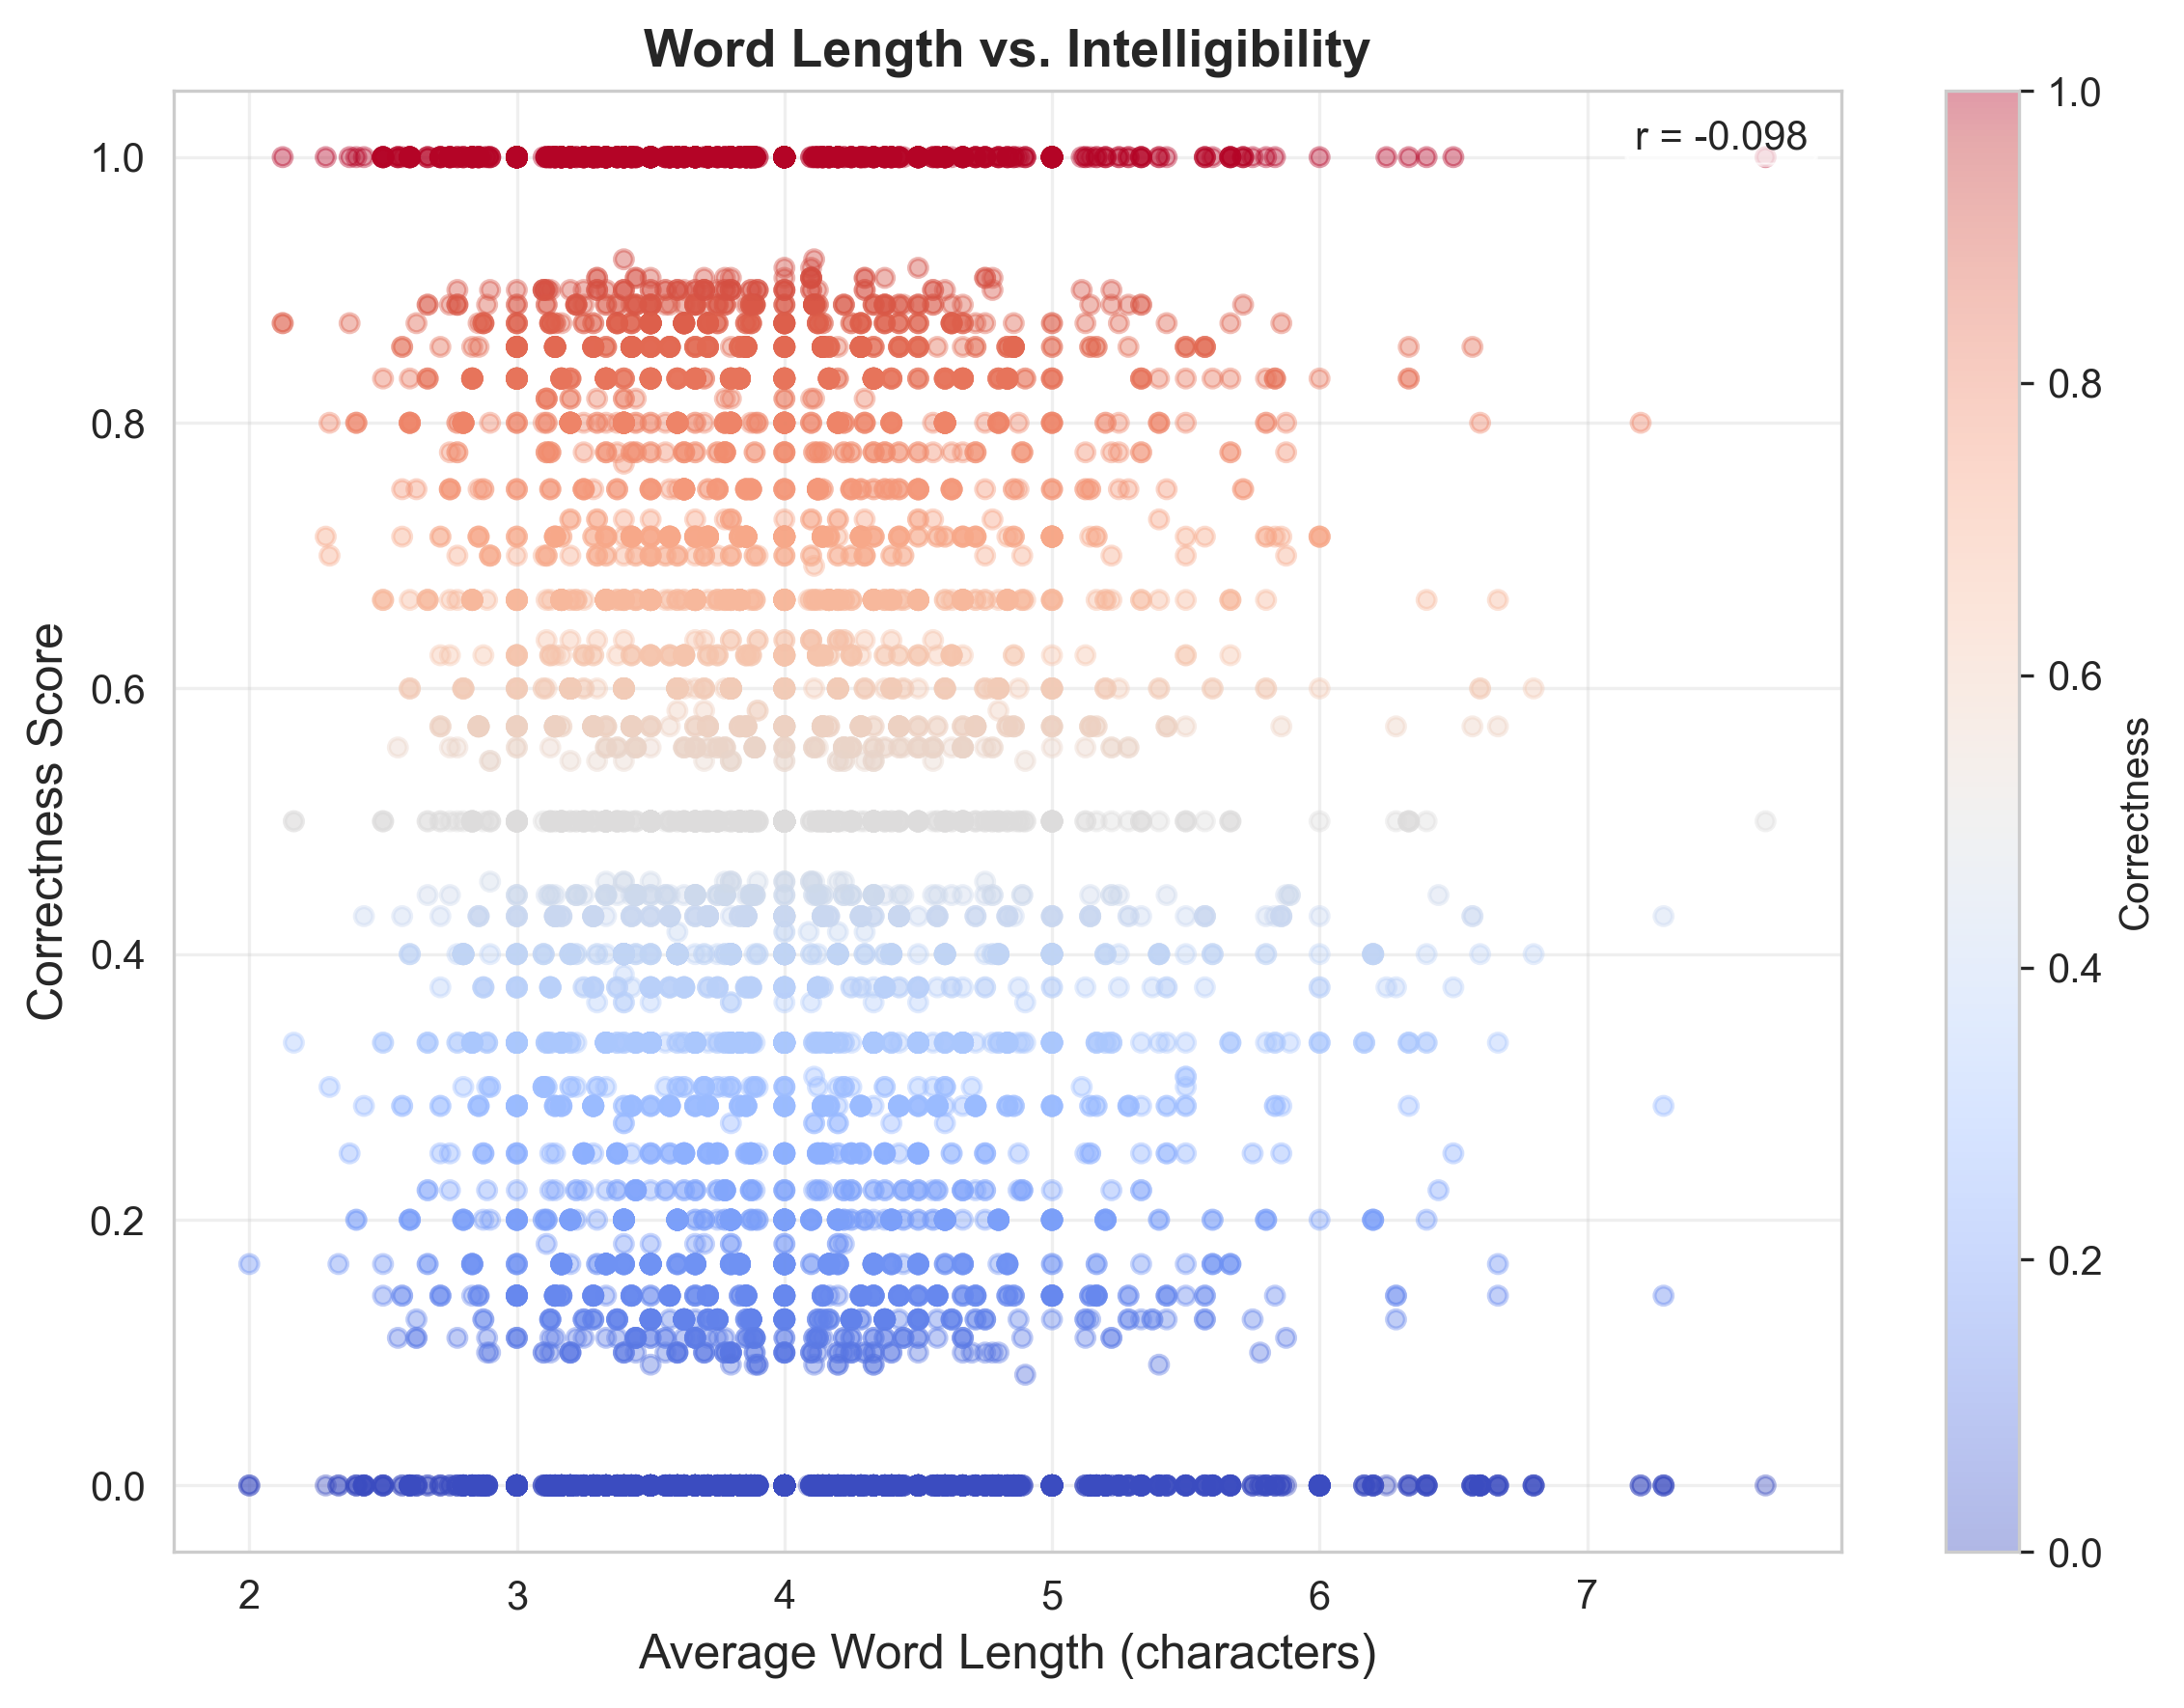

Figure 3 saved successfully!

Generating Figure 4: Word Frequency Analysis...


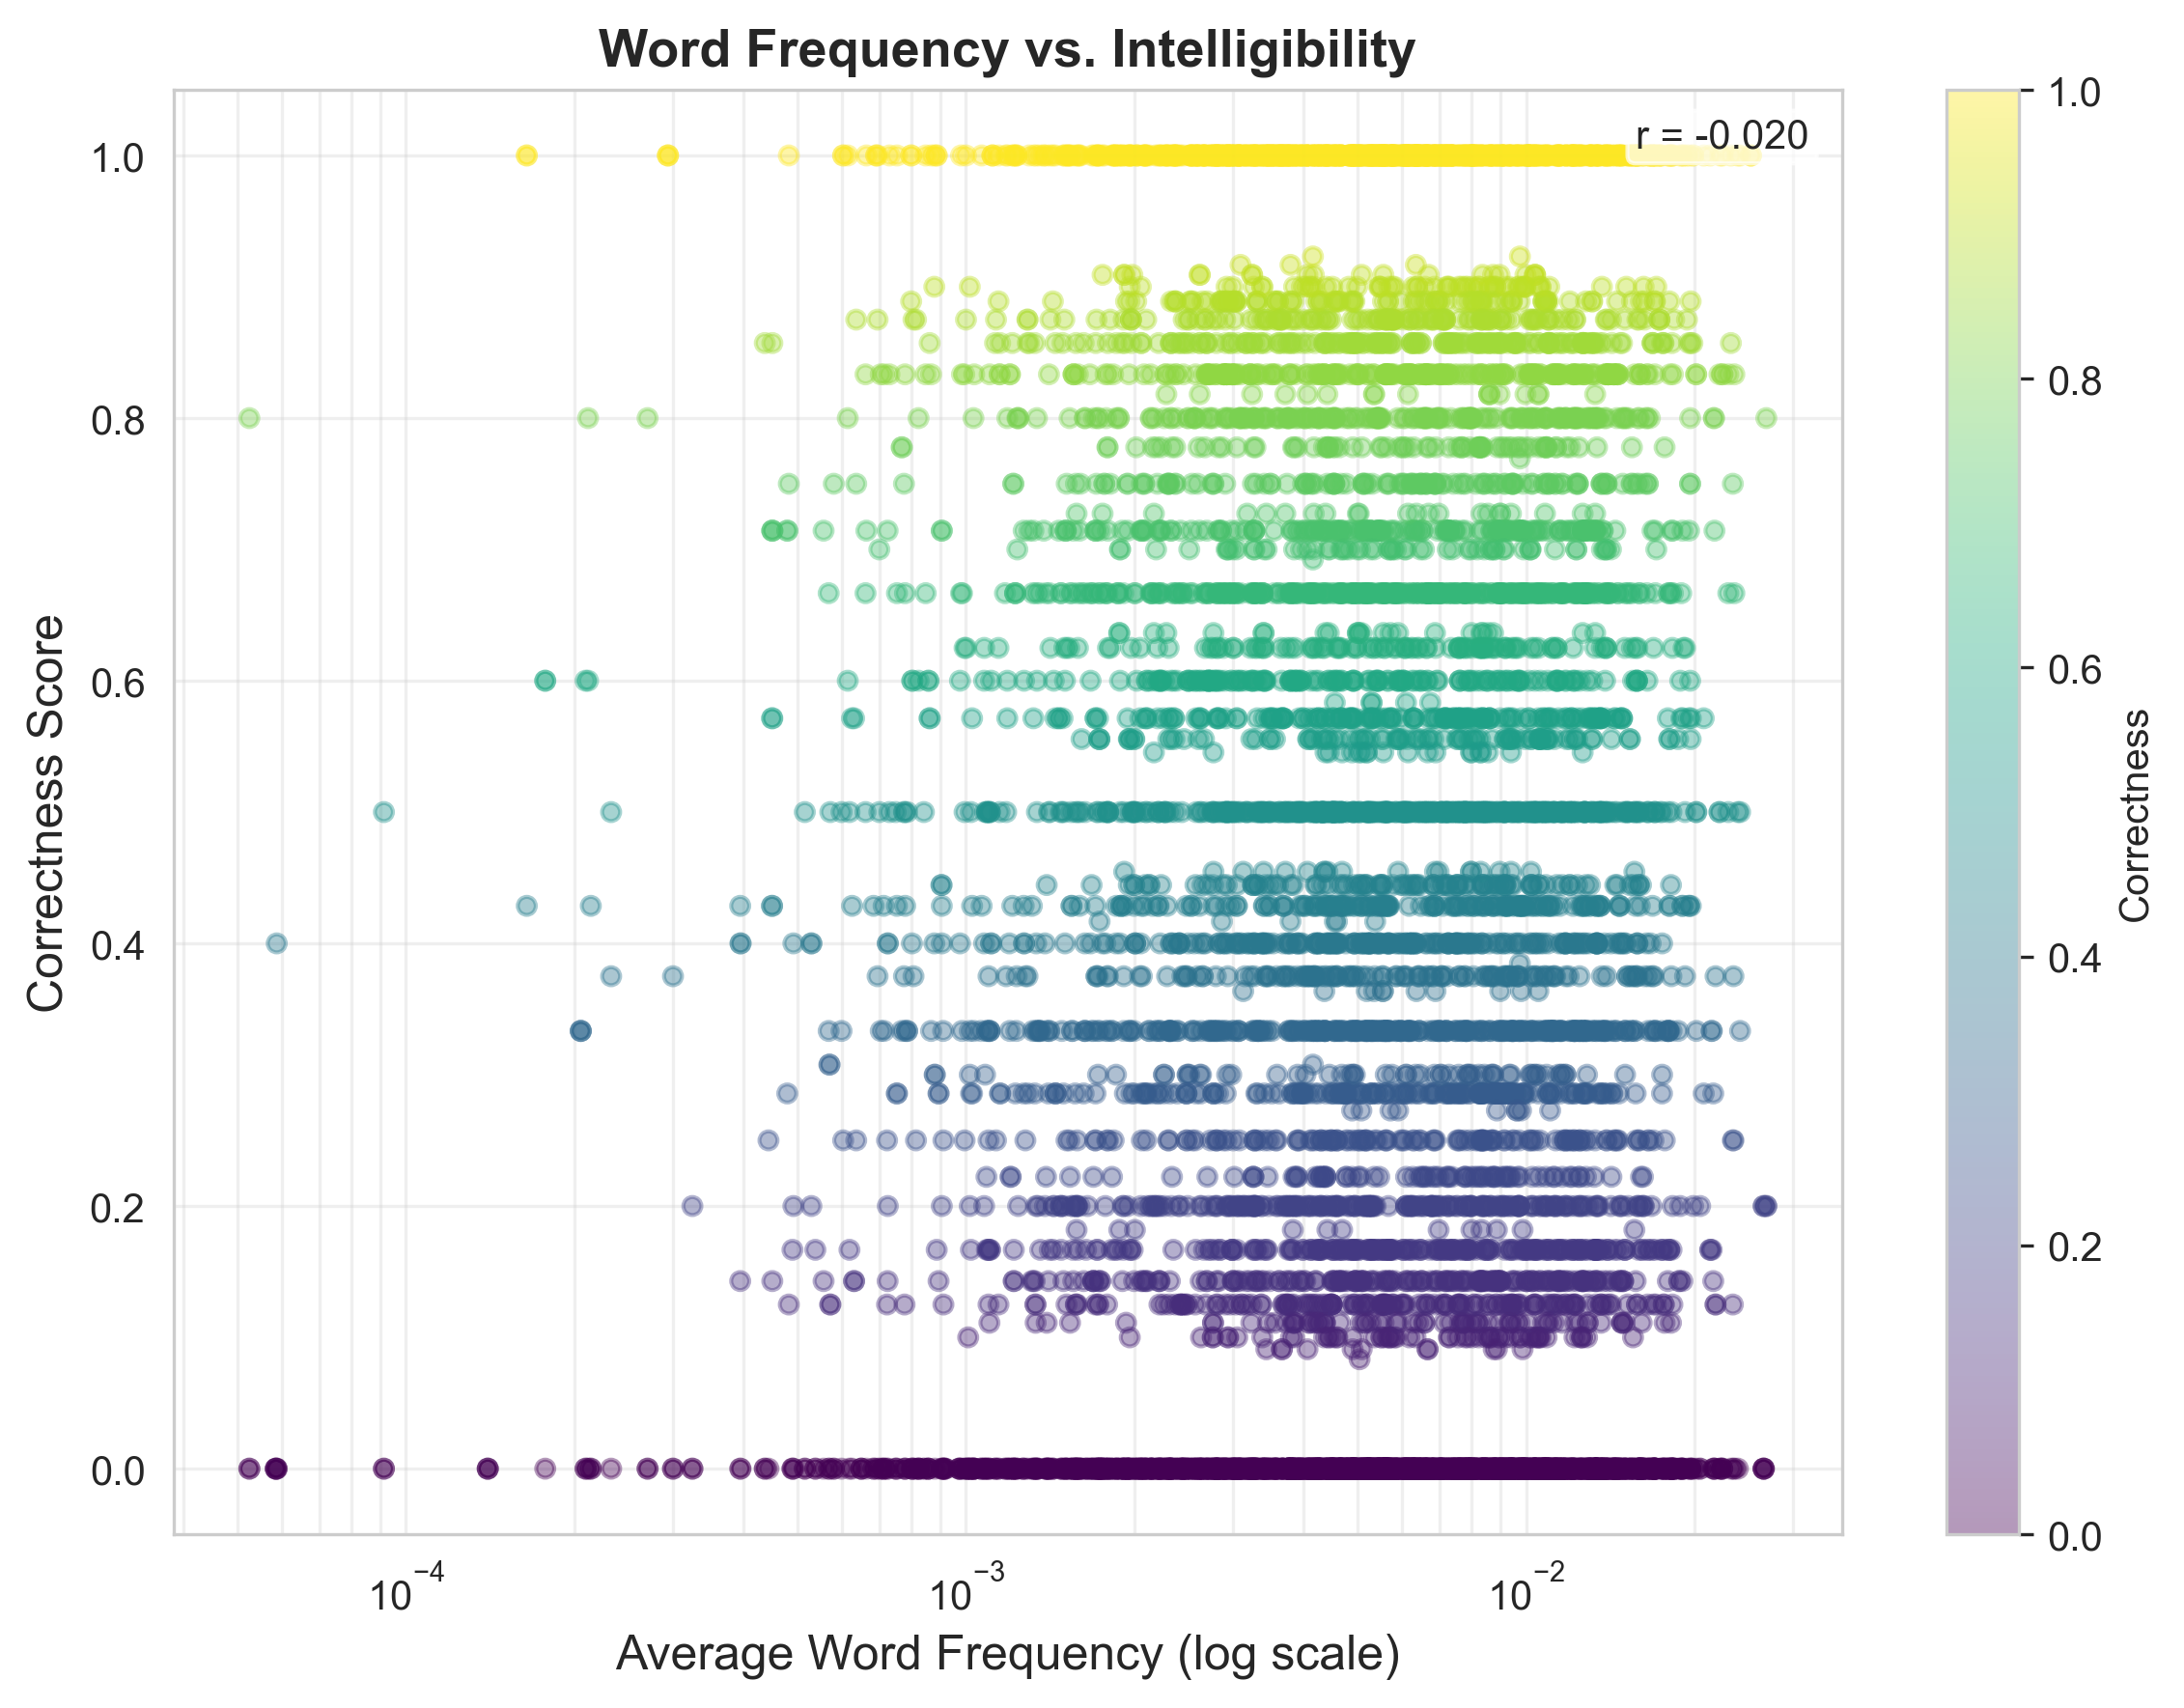

Figure 4 saved successfully!

Correlation with Correctness:
  Word Length: -0.0982
  Word Frequency: -0.0200


In [ ]:
def calculate_avg_word_length(text):
    """Calculate average word length in a text."""
    if pd.isna(text) or text == '':
        return np.nan
    words = text.split()
    if len(words) == 0:
        return np.nan
    return np.mean([len(word) for word in words])


def calculate_avg_word_frequency(text, lang='en'):
    """Calculate average word frequency using wordfreq library."""
    if pd.isna(text) or text == '':
        return np.nan
    words = text.lower().split()
    if len(words) == 0:
        return np.nan
    frequencies = [word_frequency(word, lang) for word in words]
    return np.mean(frequencies)


df['avg_word_length'] = df['prompt'].apply(calculate_avg_word_length)
df['avg_word_frequency'] = df['prompt'].apply(calculate_avg_word_frequency)

print(f"Extra features made for {len(df)} rows\n")

# FIGURE 3: Word Length vs Correctness
print("Generating Figure 3: Word Length Analysis...")
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(
    df['avg_word_length'],
    df['correctness'],
    alpha=0.4,
    s=20,
    c=df['correctness'],
    cmap='coolwarm'
)
ax.set_xlabel('Average Word Length (characters)', fontsize=12)
ax.set_ylabel('Correctness Score', fontsize=12)
ax.set_title('Word Length vs. Intelligibility', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Correctness')


try:
    r_wl = df[['avg_word_length', 'correctness']].corr().iloc[0, 1]
except Exception:
    r_wl = np.nan
text = f"r = {r_wl:.3f}" if pd.notna(r_wl) else "r = n/a"
ax.text(
    0.98,
    0.98,
    text,
    transform=ax.transAxes,
    ha='right',
    va='top',
    bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7),
    fontsize=10,
)

plt.tight_layout()
fig.savefig(PLOT_DIR / "figure_3_word_length.pdf", bbox_inches='tight')
plt.show()
print("Figure 3 saved successfully!\n")

# FIGURE 4: Word Frequency vs Correctness
print("Generating Figure 4: Word Frequency Analysis...")
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(
    df['avg_word_frequency'],
    df['correctness'],
    alpha=0.4,
    s=20,
    c=df['correctness'],
    cmap='viridis'
)
ax.set_xlabel('Average Word Frequency (log scale)', fontsize=12)
ax.set_ylabel('Correctness Score', fontsize=12)
ax.set_xscale('log')
ax.set_title('Word Frequency vs. Intelligibility', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, which='both')
plt.colorbar(scatter, ax=ax, label='Correctness')


try:
    r_wf = df[['avg_word_frequency', 'correctness']].corr().iloc[0, 1]
except Exception:
    r_wf = np.nan
text = f"r = {r_wf:.3f}" if pd.notna(r_wf) else "r = n/a"
ax.text(
    0.98,
    0.98,
    text,
    transform=ax.transAxes,
    ha='right',
    va='top',
    bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7),
    fontsize=10,
)

plt.tight_layout()
fig.savefig(PLOT_DIR / "figure_4_word_frequency.pdf", bbox_inches='tight')
plt.show()
print("Figure 4 saved successfully!\n")

print("Correlation with Correctness:")
print(f"  Word Length: {df[['avg_word_length', 'correctness']].corr().iloc[0, 1]:.4f}")
print(f"  Word Frequency: {df[['avg_word_frequency', 'correctness']].corr().iloc[0, 1]:.4f}")

## Analysis 3: Figure 5: Spectral Centroid & Figure 6: Edit Distance

Engineering acoustic features for FULL DATASET...
Processing 8802 audio files for spectral analysis...
This will take some time - processing each file sequentially.

Starting audio processing...

Spectral centroids calculated: 8802 successful
Failed: 0

Generating Figure 5: Spectral Centroid Analysis...

Spectral centroids calculated: 8802 successful
Failed: 0

Generating Figure 5: Spectral Centroid Analysis...


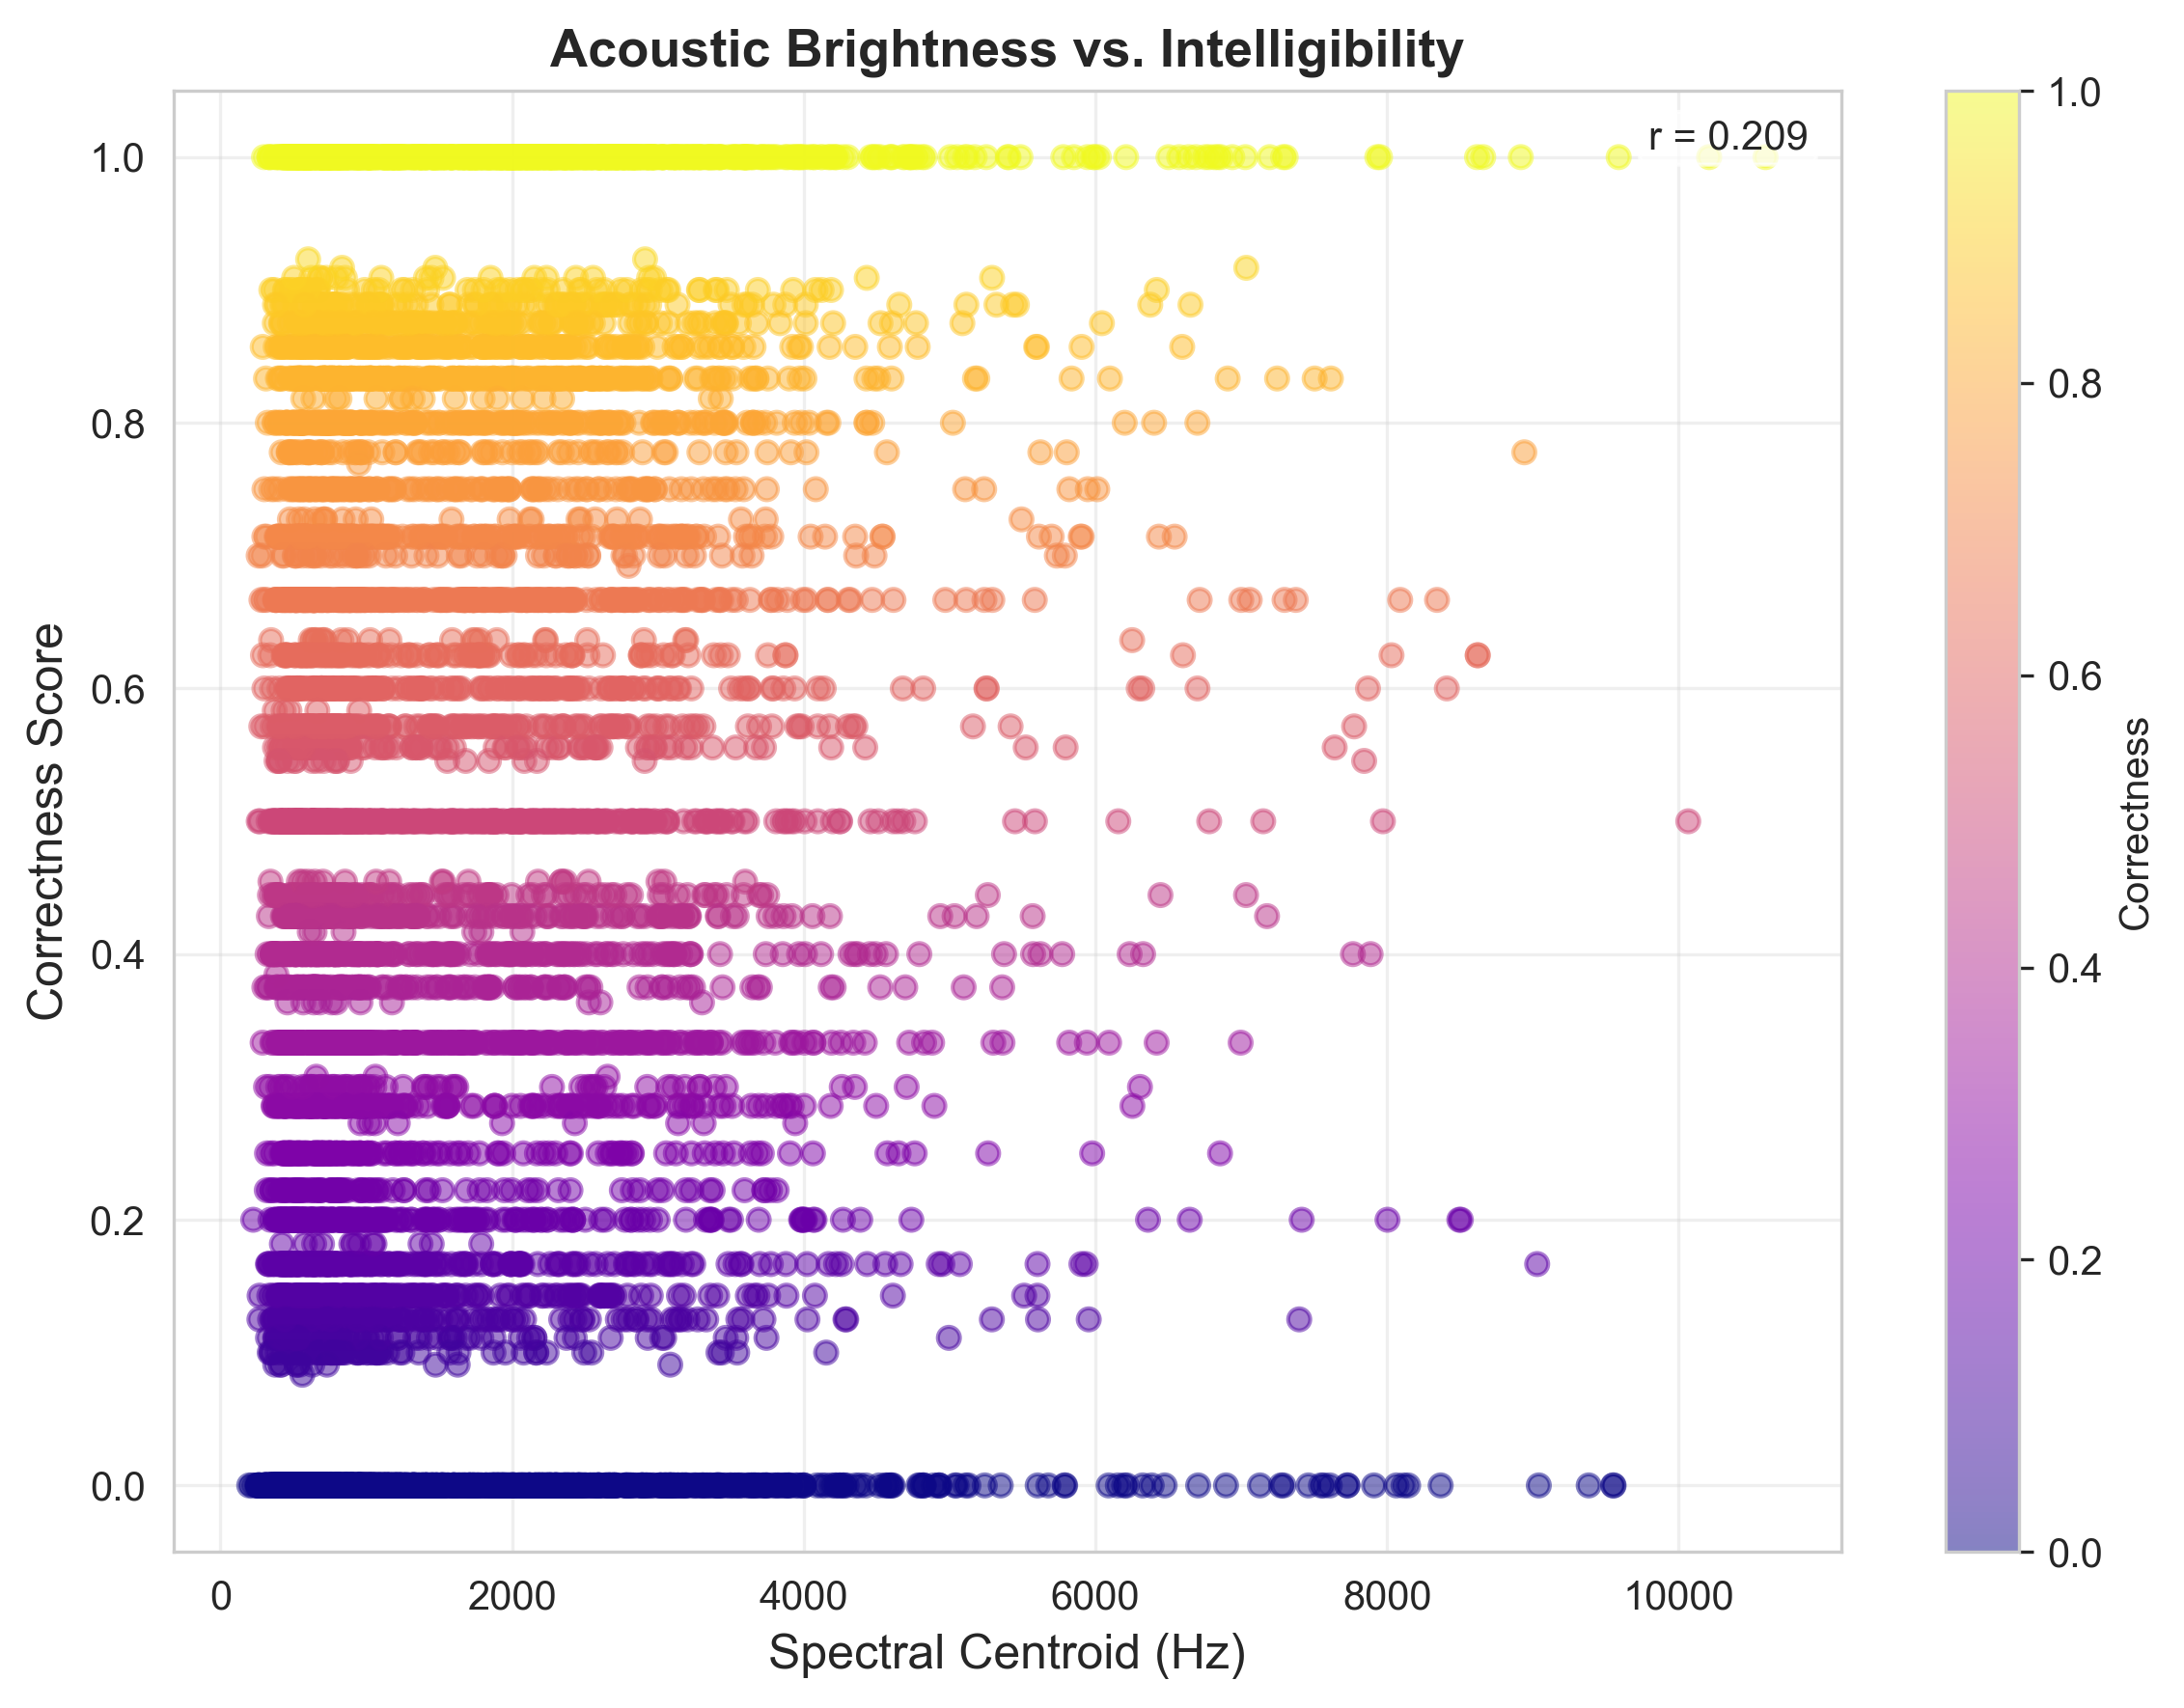

Figure 5 saved successfully!

Engineering perceptual features (edit distance)...
Edit distances calculated for 7537 responses
Rows with '#' have NaN edit_distance (as expected): 1265

Generating Figure 6: Edit Distance Analysis...


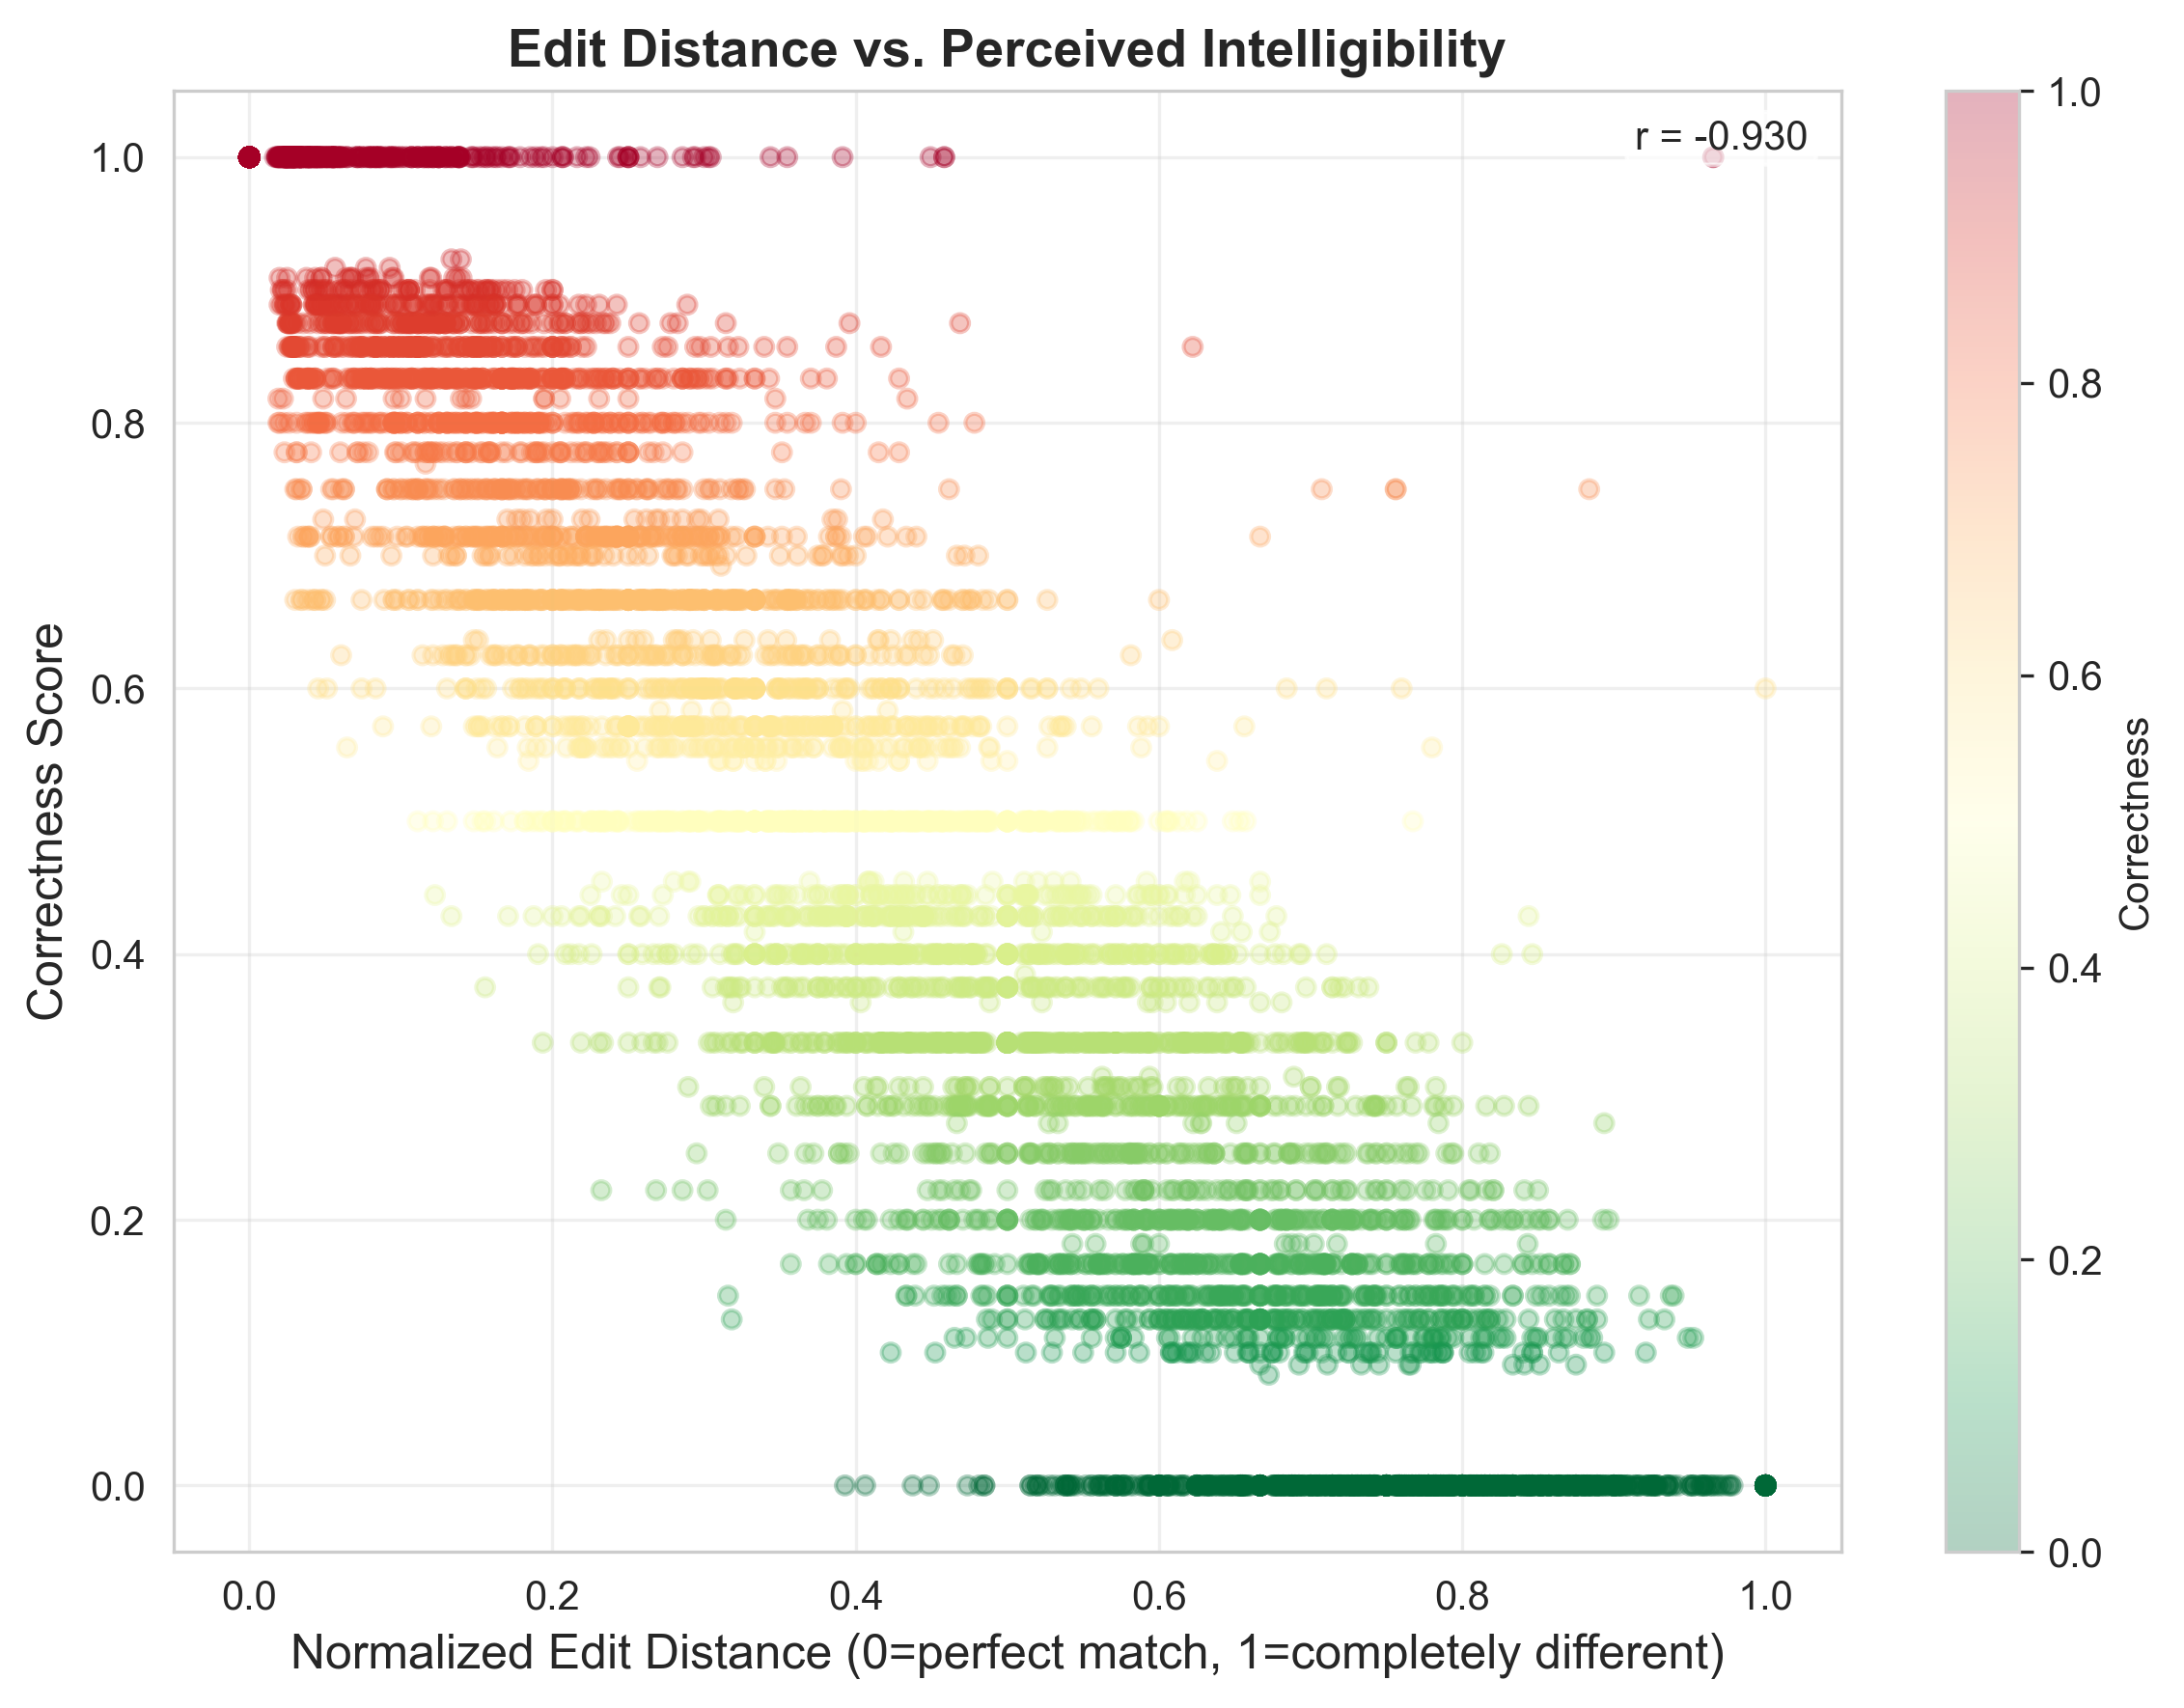

Figure 6 saved successfully!

Correlation with Correctness:
  Spectral Centroid: 0.2093
  Edit Distance: -0.9299


In [5]:
print("Engineering acoustic features for FULL DATASET...")
print(f"Processing {len(df)} audio files for spectral analysis...")
print("This will take some time - processing each file sequentially.\n")


def calculate_spectral_centroid(audio_path):
    """Calculate mean spectral centroid of an audio file."""
    try:
        y, sr = librosa.load(audio_path, sr=None)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        return np.mean(spectral_centroid)
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return np.nan


# Calculate spectral centroid for whole dataset
print(f"Starting audio processing...")
df['spectral_centroid'] = df['signal'].apply(
    lambda x: calculate_spectral_centroid(SIGNALS_DIR / f"{x}.flac")
)
print(f"\nSpectral centroids calculated: {df['spectral_centroid'].notna().sum()} successful")
print(f"Failed: {df['spectral_centroid'].isna().sum()}\n")

# FIGURE 5: Spectral Centroid vs Correctness
print("Generating Figure 5: Spectral Centroid Analysis...")
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(
    df['spectral_centroid'],
    df['correctness'],
    alpha=0.5,
    s=30,
    c=df['correctness'],
    cmap='plasma'
)
ax.set_xlabel('Spectral Centroid (Hz)', fontsize=12)
ax.set_ylabel('Correctness Score', fontsize=12)
ax.set_title('Acoustic Brightness vs. Intelligibility', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Correctness')


try:
    r_sc = df[['spectral_centroid', 'correctness']].corr().iloc[0, 1]
except Exception:
    r_sc = np.nan
text = f"r = {r_sc:.3f}" if pd.notna(r_sc) else "r = n/a"
ax.text(
    0.98,
    0.98,
    text,
    transform=ax.transAxes,
    ha='right',
    va='top',
    bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7),
    fontsize=10,
)

plt.tight_layout()
fig.savefig(PLOT_DIR / "figure_5_spectral_centroid.pdf", bbox_inches='tight')
plt.show()
print("Figure 5 saved successfully!\n")

# Edit Distances.
# '#' responses will have NaN for edit_distance_ratio since Levenshtein 
# distance is undefined for non-transcription symbols.
# Moreover, it is important to understand that '#' responses were removed
# such that it is much more clearer on how wrongly guessed the words were.
print("Engineering perceptual features (edit distance)...")


def calculate_edit_distance_ratio(row):
    """Calculate normalized Levenshtein distance between prompt and response.
    
    Returns NaN for '#' responses since edit distance is meaningless for 
    non-transcription symbols. These cases still have valid correctness scores (0.0).
    """
    prompt = str(row['prompt']).lower().strip()
    response = str(row['response']).lower().strip()
    
    # Edit distance is undefined for '#' (no transcription attempt)
    if response == '#':
        return np.nan
    
    distance = Levenshtein.distance(prompt, response)
    max_len = max(len(prompt), len(response))
    
    return distance / max_len if max_len > 0 else 0


# Apply to dataset
df['edit_distance_ratio'] = df.apply(calculate_edit_distance_ratio, axis=1)
print(f"Edit distances calculated for {df['edit_distance_ratio'].notna().sum()} responses")
print(f"Rows with '#' have NaN edit_distance (as expected): {df['edit_distance_ratio'].isna().sum()}\n")

# FIGURE 6: Edit Distance vs Correctness (using full dataset)
print("Generating Figure 6: Edit Distance Analysis...")
fig, ax = plt.subplots(figsize=(8, 6))

# Plot only rows where edit_distance_ratio is defined (not '#' responses)
df_with_edit_dist = df[df['edit_distance_ratio'].notna()]
scatter = ax.scatter(
    df_with_edit_dist['edit_distance_ratio'],
    df_with_edit_dist['correctness'],
    alpha=0.3,
    s=20,
    c=df_with_edit_dist['correctness'],
    cmap='RdYlGn_r'
)
ax.set_xlabel('Normalized Edit Distance (0=perfect match, 1=completely different)', fontsize=12)
ax.set_ylabel('Correctness Score', fontsize=12)
ax.set_title('Edit Distance vs. Perceived Intelligibility', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Correctness')


try:
    r_ed = df[['edit_distance_ratio', 'correctness']].dropna()[['edit_distance_ratio', 'correctness']].corr().iloc[0, 1]
except Exception:
    r_ed = np.nan
text = f"r = {r_ed:.3f}" if pd.notna(r_ed) else "r = n/a"
ax.text(
    0.98,
    0.98,
    text,
    transform=ax.transAxes,
    ha='right',
    va='top',
    bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7),
    fontsize=10,
)

plt.tight_layout()
fig.savefig(PLOT_DIR / "figure_6_edit_distance.pdf", bbox_inches='tight')
plt.show()
print("Figure 6 saved successfully!\n")

# Display correlation statistics
print("Correlation with Correctness:")
print(f"  Spectral Centroid: {df[['spectral_centroid', 'correctness']].corr().iloc[0, 1]:.4f}")
print(f"  Edit Distance: {df[['edit_distance_ratio', 'correctness']].corr().iloc[0, 1]:.4f}")

### Figure 7: Correctness score vs Mild/Moderate/No Hearing Loss Avg Word Length

Generating Figure 7: Synthesis & Interaction Analysis...
Using full dataset: 8802 samples



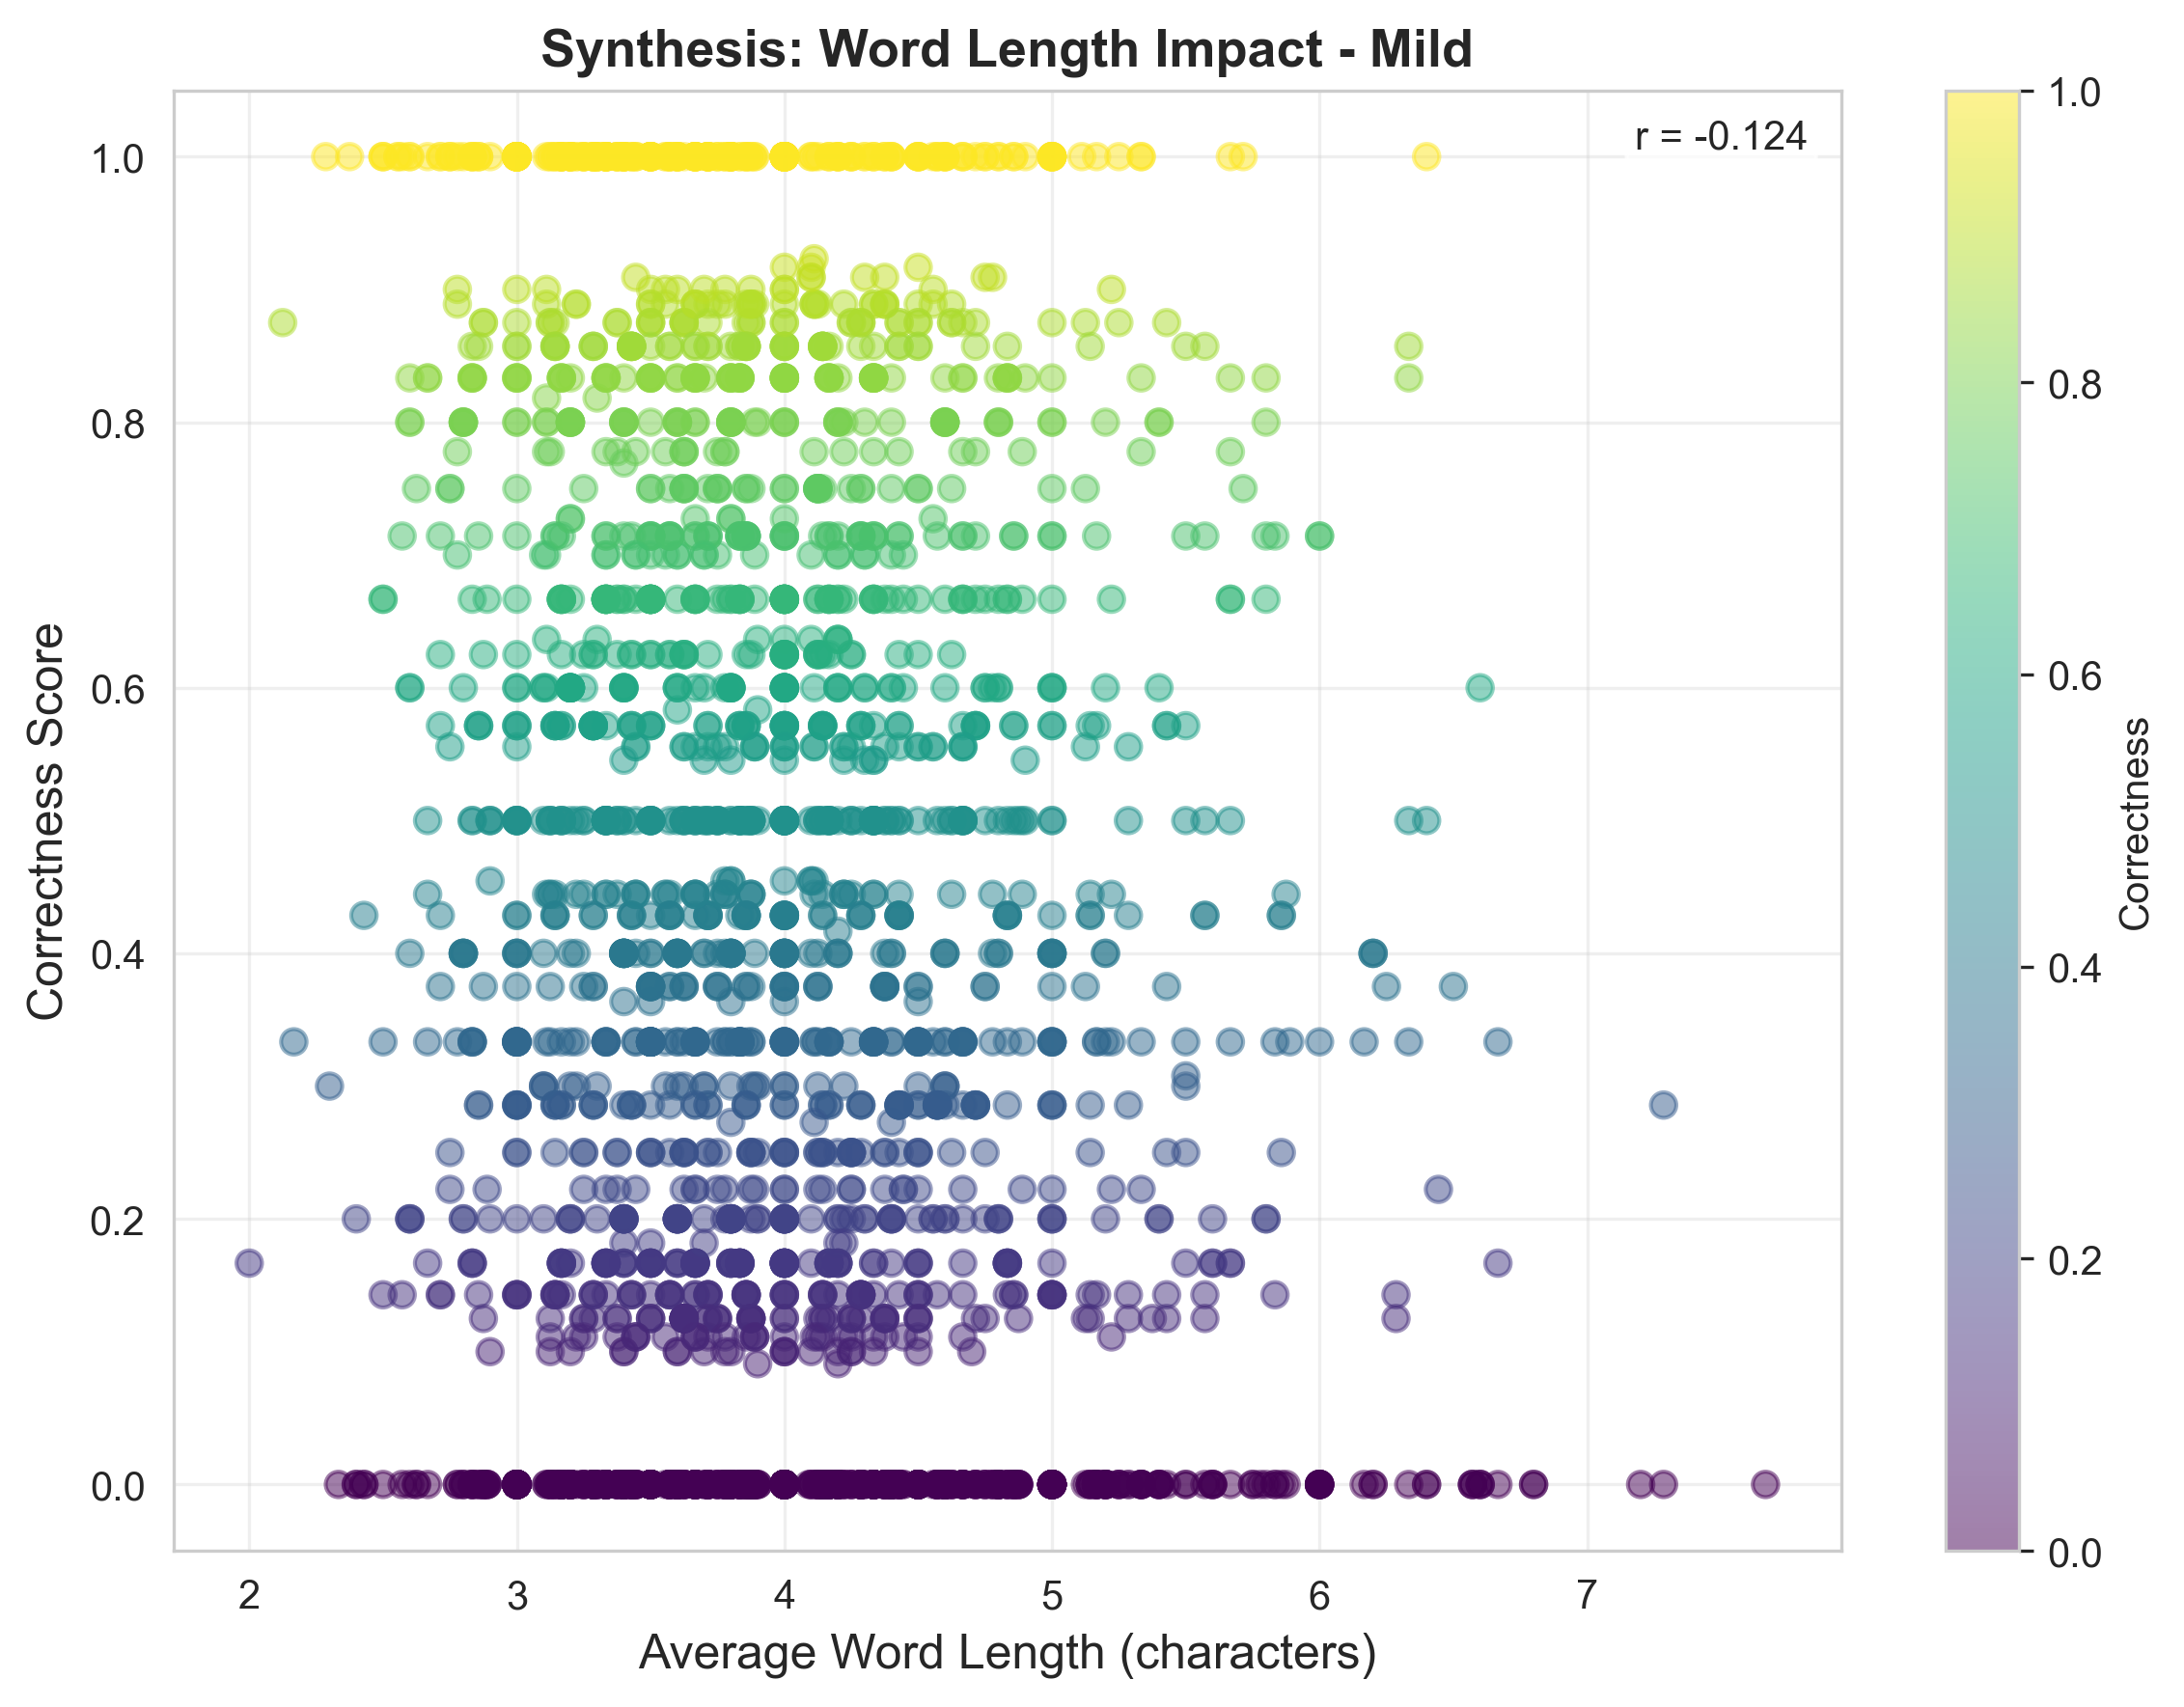

Figure 7a (Mild) saved successfully!



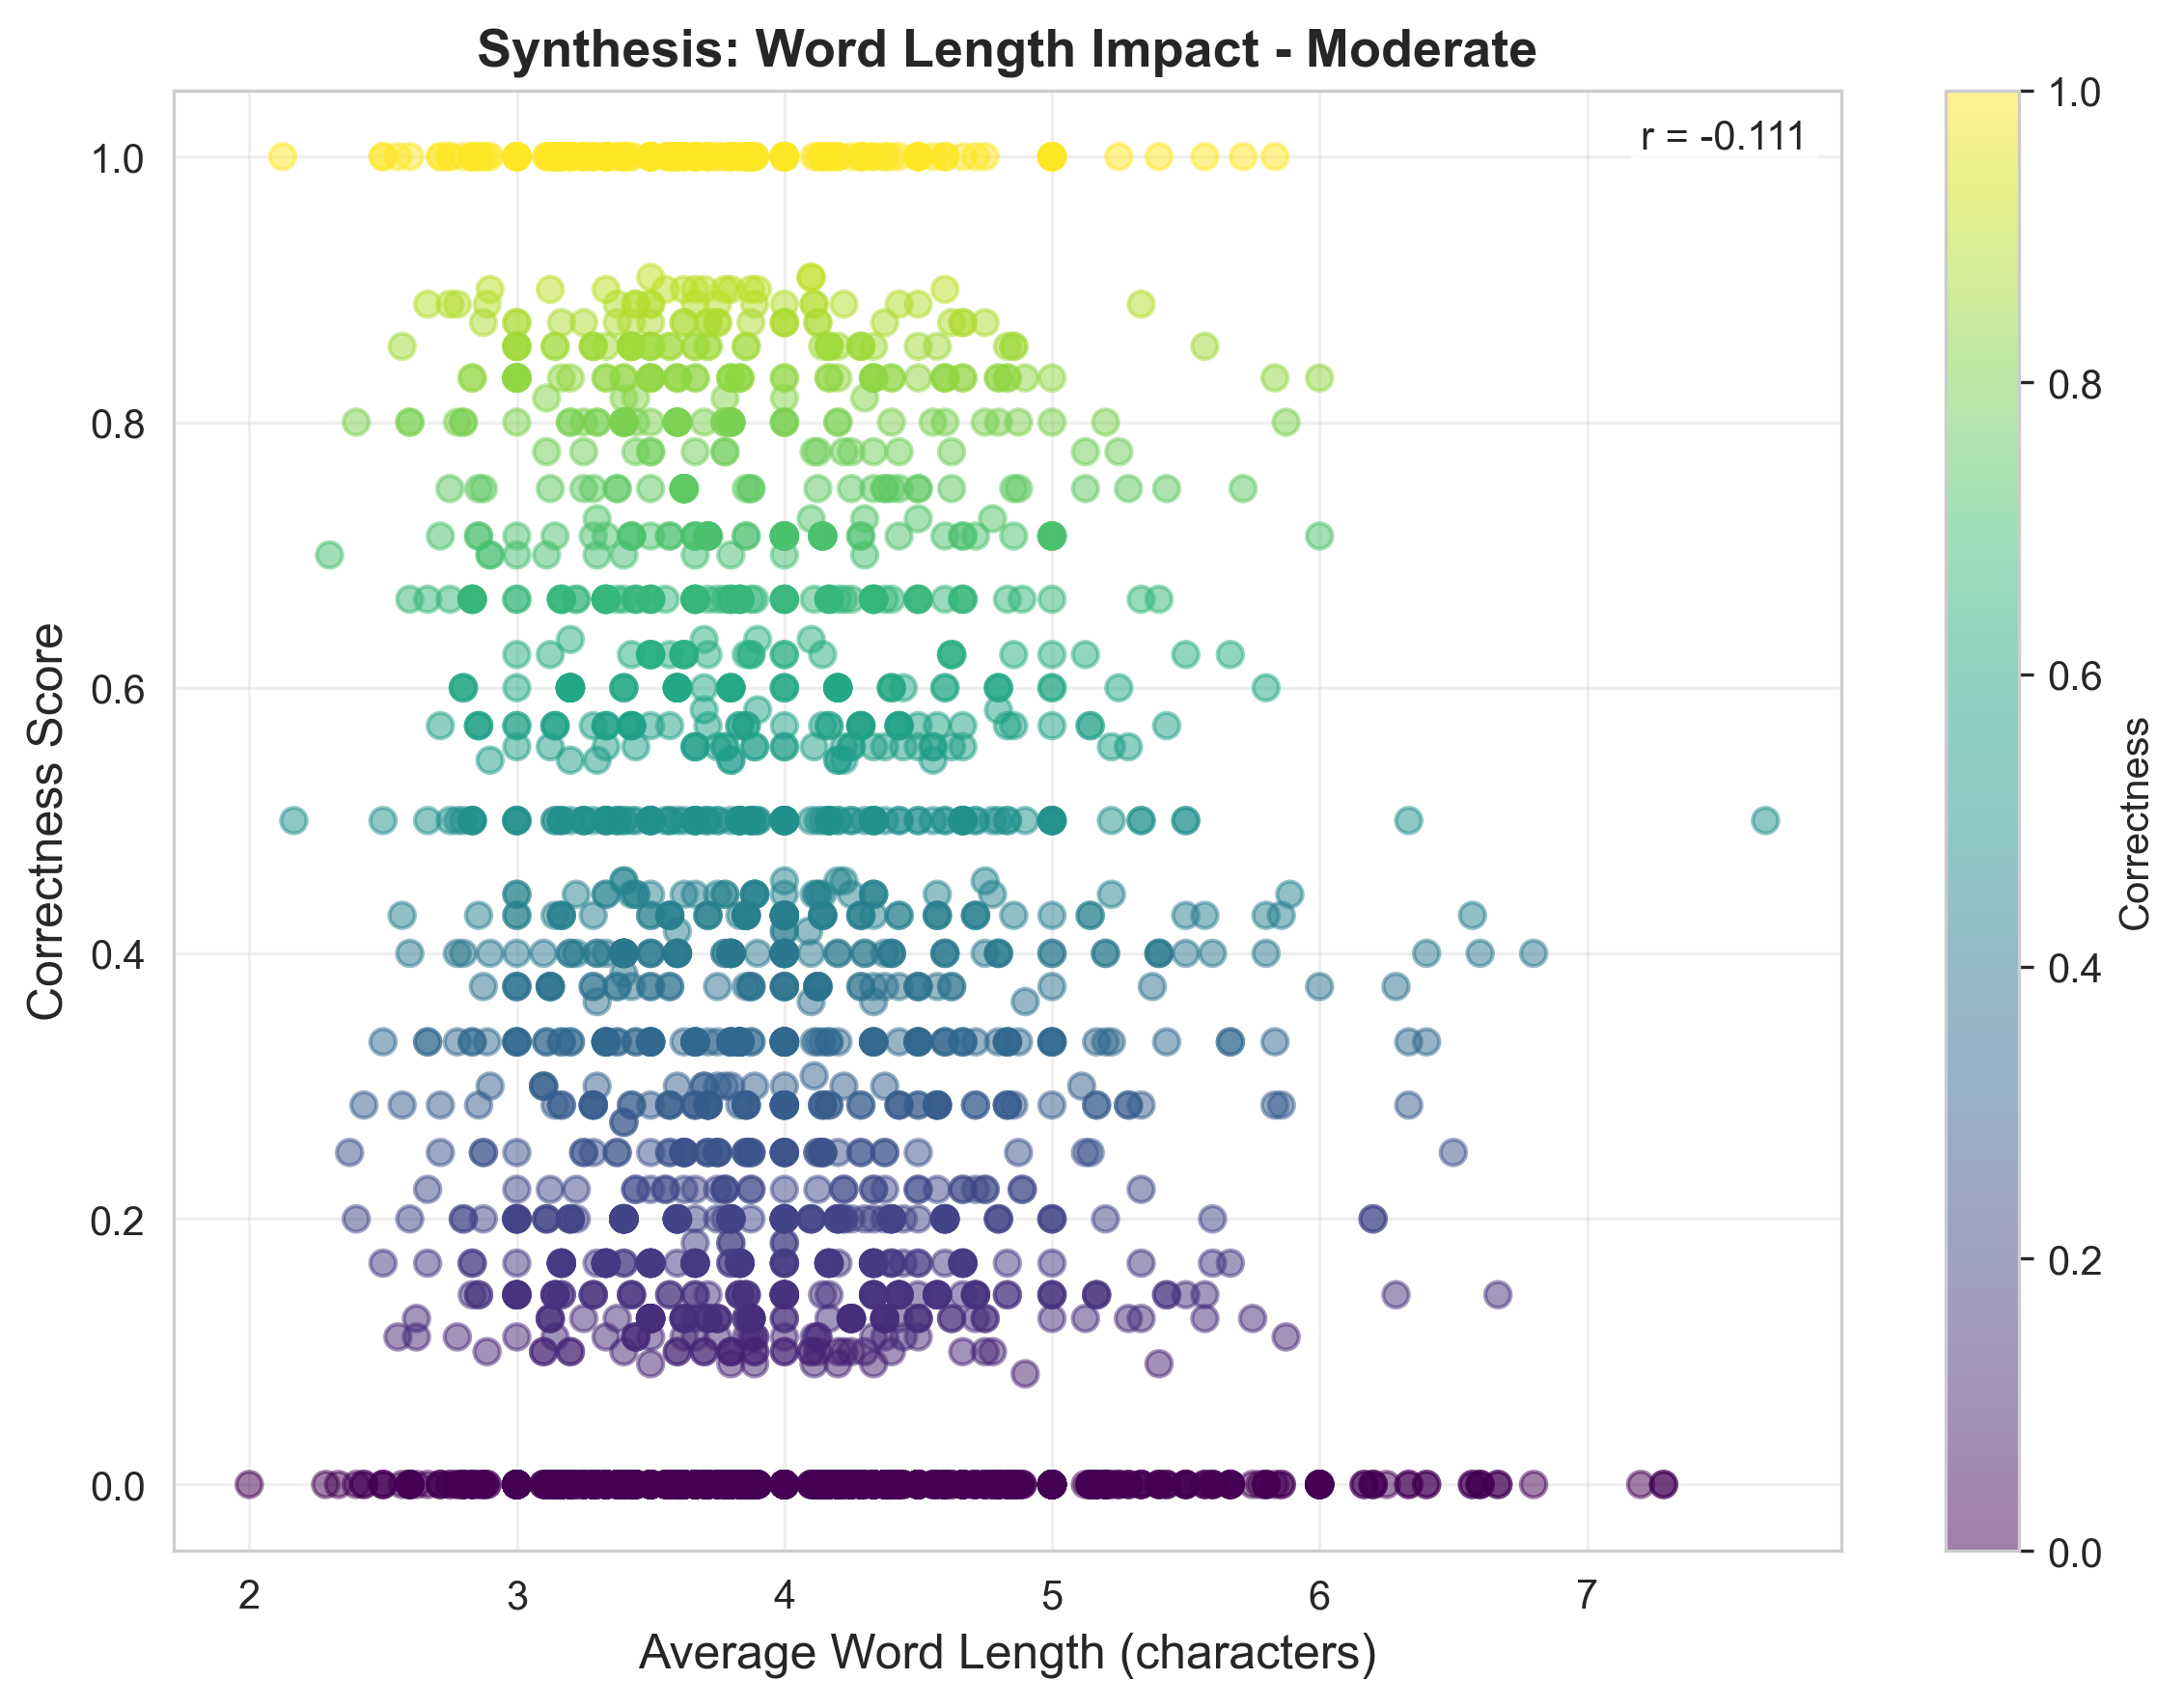

Figure 7b (Moderate) saved successfully!



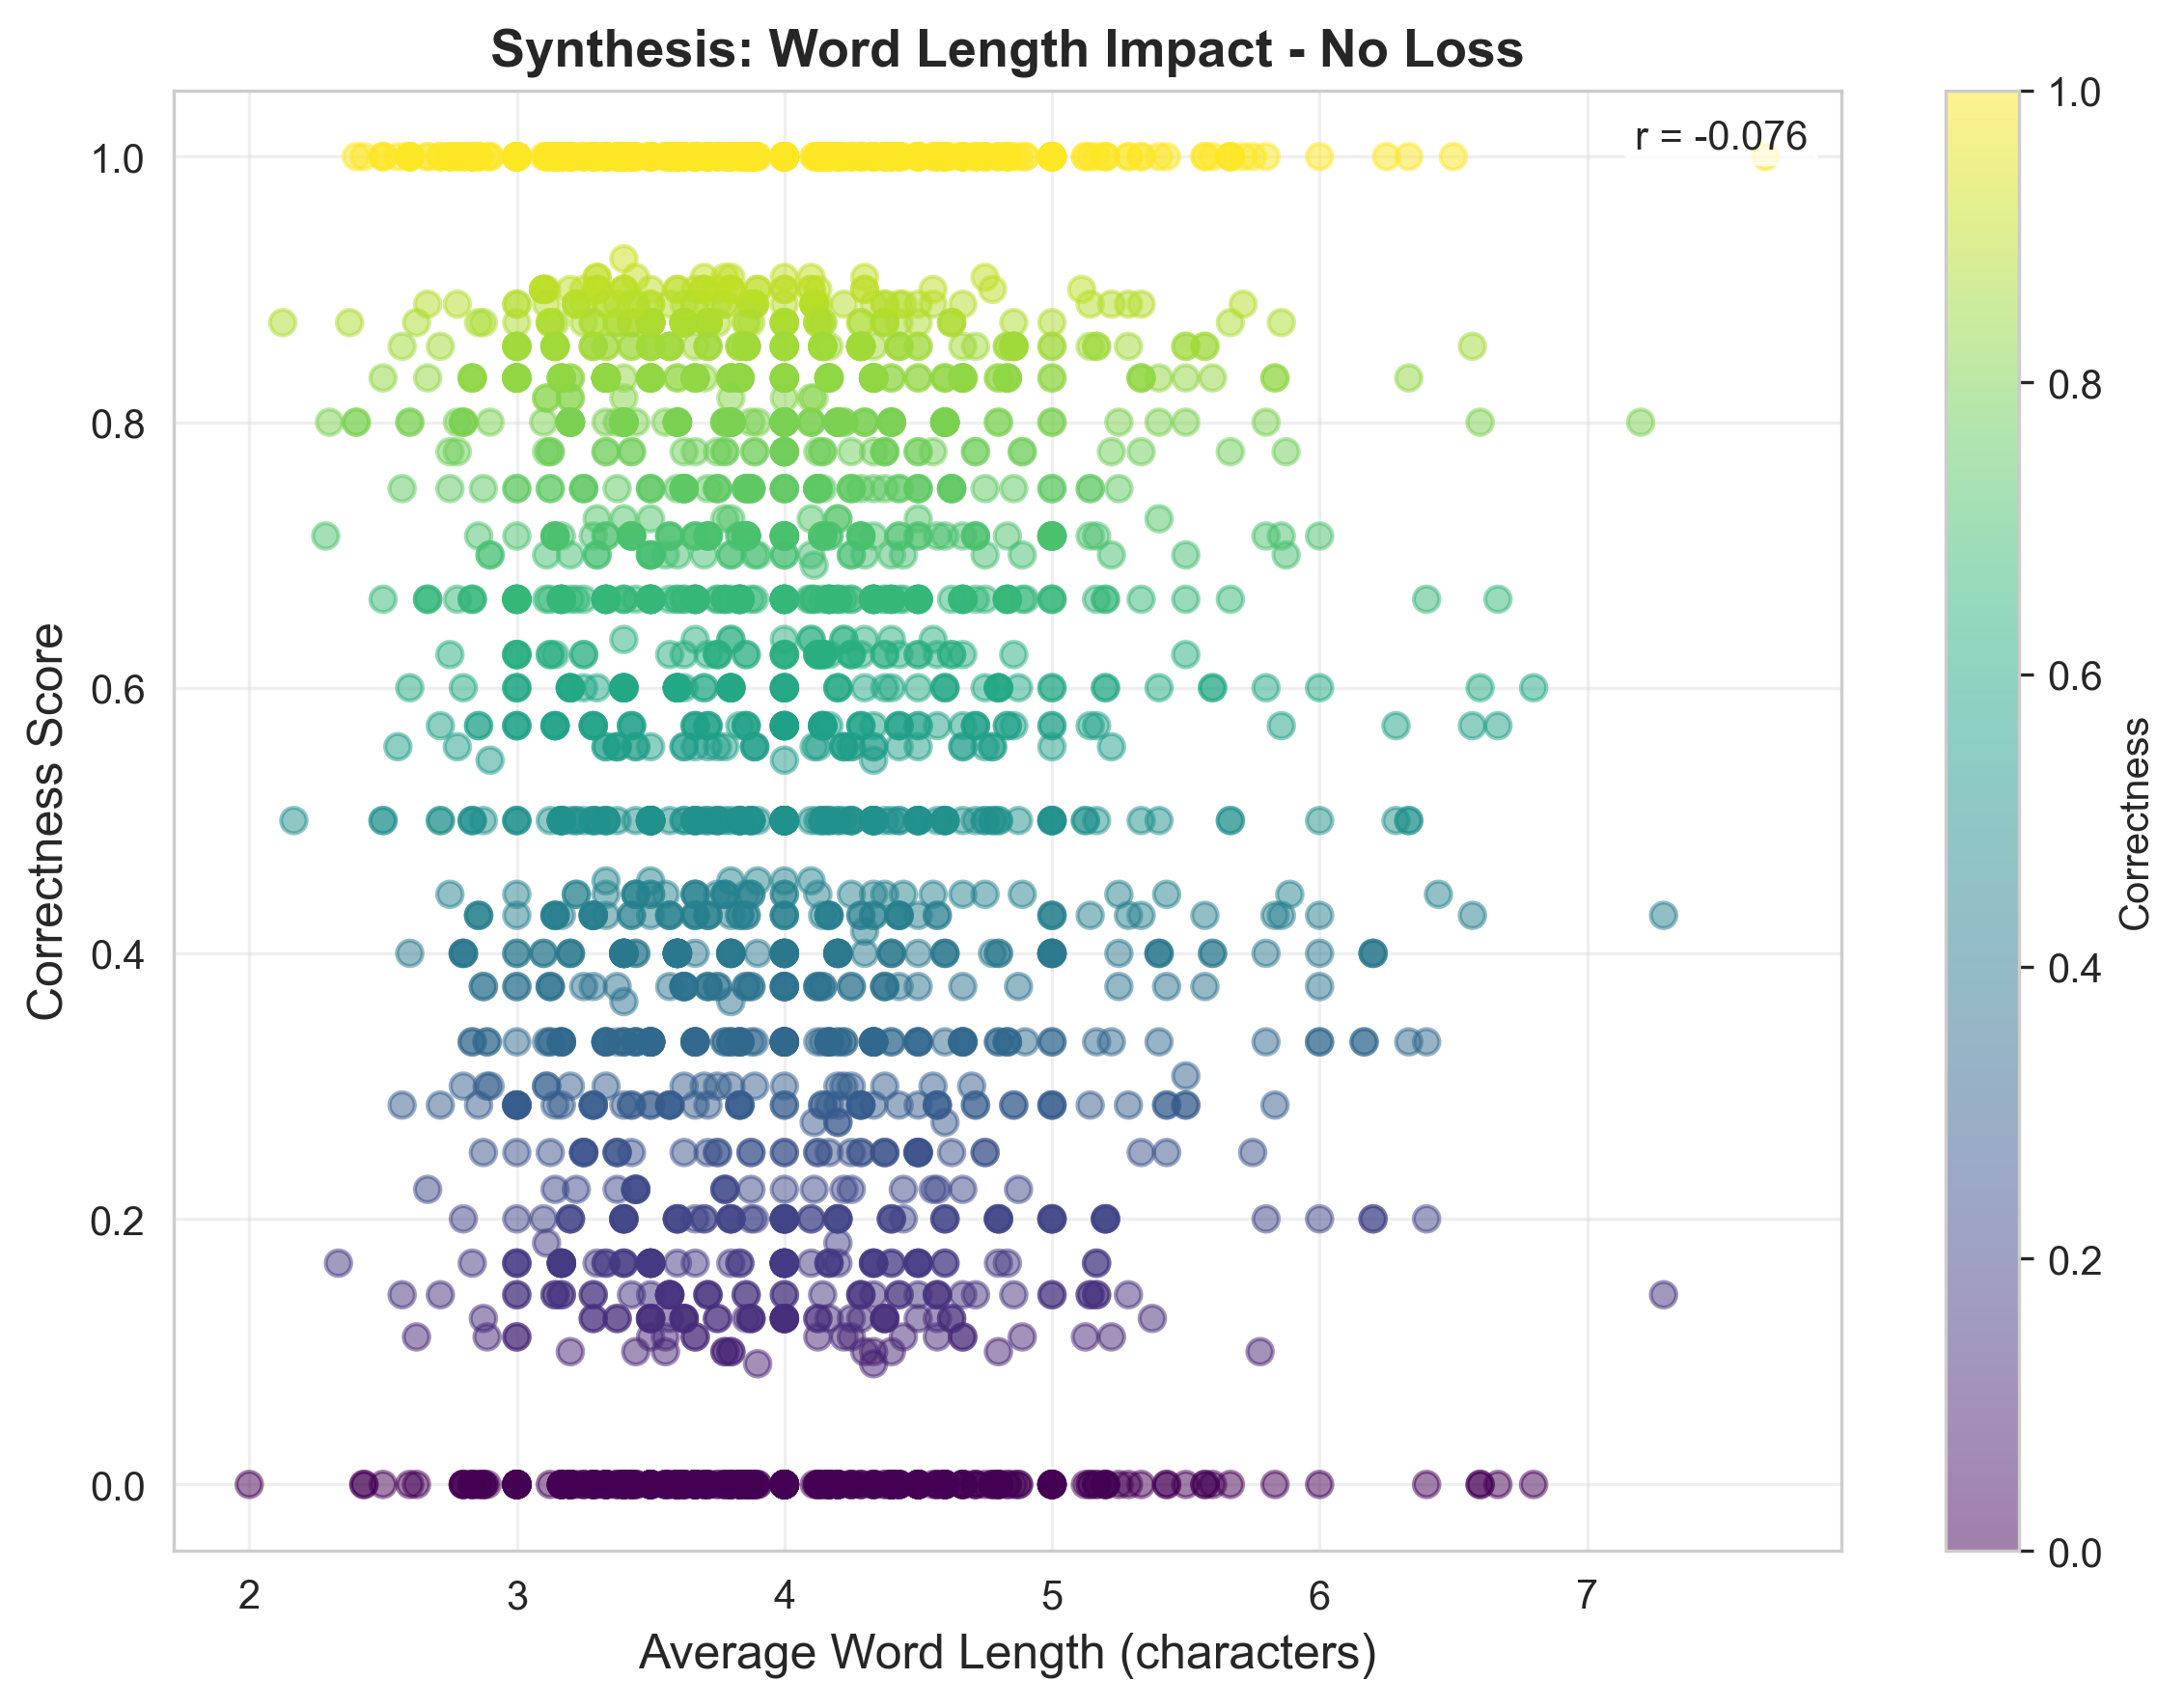

Figure 7c (No Loss) saved successfully!


SUMMARY STATISTICS BY HEARING LOSS CATEGORY
             correctness               avg_word_length avg_word_frequency  \
                    mean     std count            mean               mean   
hearing_loss                                                                
Mild              0.3953  0.3477  2935          3.9556             0.0068   
Moderate          0.3163  0.3340  2934          3.9547             0.0068   
No Loss           0.5793  0.3391  2933          3.9557             0.0068   

             spectral_centroid  
                          mean  
hearing_loss                    
Mild                 1217.5424  
Moderate              977.3325  
No Loss              2482.2728  

ALL FIGURES GENERATED SUCCESSFULLY!

Figures saved to: g:\My Drive\musab\BSCS 14B Musab\Musab BSCS 14B files\Semester 3\Artificial Intelligence\sem_3_ai_sem_proj\plots

Generated figures:
  - Figure 1: figure_1_target_distribution.pdf
  - Figure 2: fig

In [6]:
# FIGURE 7: Synthesis - Interaction between features by hearing loss
print("Generating Figure 7: Synthesis & Interaction Analysis...")

# Use full dataset with all engineered features
# All features are already in df (avg_word_length, avg_word_frequency, spectral_centroid)
print(f"Using full dataset: {len(df)} samples\n")

# Create separate plots for each hearing loss category
hearing_loss_categories = df['hearing_loss'].unique()
hearing_loss_categories.sort()

for idx, hl_category in enumerate(hearing_loss_categories, start=1):
    # Filter data for this hearing loss category
    df_hl = df[df['hearing_loss'] == hl_category]
    
    # Create individual figure
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Scatter plot
    scatter = ax.scatter(
        df_hl['avg_word_length'],
        df_hl['correctness'],
        alpha=0.5,
        s=40,
        c=df_hl['correctness'],
        cmap='viridis'
    )

    
    try:
        r_hl = df_hl[['avg_word_length', 'correctness']].corr().iloc[0, 1]
    except Exception:
        r_hl = np.nan
    text = f"r = {r_hl:.3f}" if pd.notna(r_hl) else "r = n/a"
    ax.text(
        0.98,
        0.98,
        text,
        transform=ax.transAxes,
        ha='right',
        va='top',
        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7),
        fontsize=10,
    )
    
    ax.set_xlabel('Average Word Length (characters)', fontsize=12)
    ax.set_ylabel('Correctness Score', fontsize=12)
    ax.set_title(f'Synthesis: Word Length Impact - {hl_category}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Correctness')
    
    plt.tight_layout()
    
    # Save with appropriate label (7a, 7b, 7c)
    fig_label = chr(96 + idx)  # 'a', 'b', 'c'
    fig.savefig(PLOT_DIR / f"figure_7{fig_label}_synthesis_interaction_{hl_category}.pdf", bbox_inches='tight')
    plt.show()
    print(f"Figure 7{fig_label} ({hl_category}) saved successfully!\n")

# Summary Statistics by Hearing Loss
print("\n" + "="*60)
print("SUMMARY STATISTICS BY HEARING LOSS CATEGORY")
print("="*60)
summary = df.groupby('hearing_loss').agg({
    'correctness': ['mean', 'std', 'count'],
    'avg_word_length': 'mean',
    'avg_word_frequency': 'mean',
    'spectral_centroid': 'mean'
}).round(4)
print(summary)

print("\n" + "="*60)
print("ALL FIGURES GENERATED SUCCESSFULLY!")
print("="*60)
print(f"\nFigures saved to: {PLOT_DIR}")
print("\nGenerated figures:")
for i in range(1, 7):
    print(f"  - Figure {i}: {list(PLOT_DIR.glob(f'figure_{i}_*.pdf'))[0].name}")
print(f"  - Figure 7a, 7b, 7c: {[f.name for f in PLOT_DIR.glob('figure_7*.pdf')]}")